In [1]:
# # uses table taken from scb excel sheet 2
# df = pd.read_csv('scb_dead_per_age.csv',sep=';',header=None,usecols=range(19),index_col=0)

### ASSUME population for 2020 increases by age group as it did from 2018 to 2019

#### !!!!! ANOMALY in SCB data: historical death data for (at least ) 2019 from statistikdatabasen 
# http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/ManadFoddDod/table/tableViewLayout1/
# does not concur with death data 2019 in the preliminary data! 

### DUE to okänd dödsdag when using the daily data of the preliminary stuff - much more okänd dag than okänd månad in 
### the monthly stuff
####

# ALL DATA BASED ON SCB PREL DATA IGNORES THOSE WITH UNKNOWN DAY OF DEATH !!!


##### LESSONS LEARNED :
# 1) DONT SUM AVERAGES : DEATH RATES MUST BE CONVERTED TO ABSOLUTE NUMBERS BEFORE SUMMING AGE CATEGORIES,
#    AND FIRST THEN CONVERT BACK TO NEW RATES !!! EXAMPLE: 100 CATEGORIES OF AGE EACH WITH RATE OF 2% SUMS TO 200%...!

### ASSUMPTIONS : 2020 NR DEATHS WILL GROW LINEARLY DEATHS = (1 / (NR_DATA_DAYS / 365)) * CURRENT_DEATHS

#### POPULATION AGE STRUCTURE FOR 2020 SAME AS FOR 2019

# standardization algorithm from : https://www.healthknowledge.org.uk/e-learning/epidemiology/specialists/standardisation


import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

In [2]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    
    #df = df.drop('Månad',axis=1)
    
    index = pd.date_range('2020-01-01',periods=len(df))
    df.index = index
    
    known_death_day = df.iloc[:,:7].sum()
    
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] 
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    all_deaths = pd.concat([all_deaths,df['Månad']],axis=1)
    
    return all_deaths

In [3]:
daily_deaths = parse_scb_prel()
year_fraction = len(daily_deaths) / 366

In [4]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/Dodstal'

data = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "4"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [5]:
r = requests.post(url,json=data)
r.status_code

json = r.json()

In [6]:
#parse death data from json to df 

data_list = []

nr_records = (len(json['data']))

for rec in range(nr_records):

    data_list.append ((json['data'][rec]['key'][0],json['data'][rec]['key'][2],json['data'][rec]['values'][0]))

In [7]:
# death rate df from SCB data, deaths per 1000

death_rate = pd.DataFrame(data_list,columns=['age_grp','year','dead_per_1k'])
death_rate

,age_grp,year,dead_per_1k
0,0,2000,3.42
1,0,2001,3.65
2,0,2002,3.27
3,0,2003,3.11
4,0,2004,3.11
...,...,...,...
395,90+,2015,231.68
396,90+,2016,232.57
397,90+,2017,235.55
398,90+,2018,231.67


In [8]:
death_rate['year'] = death_rate['year'].astype(int)
death_rate['dead_per_1k'] = death_rate['dead_per_1k'].astype(float)

# make age_grp categorial for correct sorting
death_rate['age_grp'] = pd.Categorical(death_rate['age_grp'],['0','1-4','5-9','10-14','15-19','20-24','25-29',
                                             '30-34','35-39','40-44','45-49','50-54','55-59',
                                             '60-64','65-69','70-74','75-79','80-84',
                                             '85-89','90+'])


In [9]:
death_rate_idx = ['0','1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90+']

In [10]:
#pivot for easier handling
death_rate = pd.pivot(death_rate,index='year',columns='age_grp',values='dead_per_1k')
death_rate = death_rate.T

death_rate.index = death_rate_idx
death_rate

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,3.42,3.65,3.27,3.11,3.11,2.43,2.80,2.49,2.49,2.49,2.54,2.10,2.59,2.69,2.18,2.45,2.49,2.41,2.03,2.07
1-4,0.12,0.19,0.19,0.20,0.13,0.21,0.17,0.17,0.14,0.20,0.15,0.13,0.13,0.11,0.11,0.13,0.13,0.10,0.14,0.12
5-9,0.10,0.09,0.07,0.09,0.09,0.10,0.09,0.09,0.06,0.09,0.06,0.09,0.07,0.06,0.07,0.07,0.08,0.06,0.05,0.05
10-14,0.13,0.12,0.11,0.10,0.10,0.10,0.09,0.08,0.11,0.11,0.09,0.09,0.10,0.08,0.07,0.11,0.08,0.09,0.11,0.07
15-19,0.36,0.30,0.33,0.34,0.32,0.26,0.31,0.32,0.29,0.27,0.27,0.28,0.24,0.24,0.24,0.23,0.20,0.24,0.25,0.24
20-24,0.51,0.52,0.53,0.48,0.55,0.47,0.50,0.47,0.48,0.45,0.46,0.44,0.43,0.43,0.45,0.46,0.38,0.43,0.48,0.45
25-29,0.50,0.46,0.45,0.47,0.48,0.50,0.43,0.50,0.53,0.47,0.50,0.49,0.48,0.54,0.49,0.55,0.50,0.55,0.50,0.47
30-34,0.52,0.56,0.55,0.50,0.48,0.49,0.50,0.48,0.54,0.48,0.50,0.53,0.49,0.52,0.62,0.55,0.58,0.55,0.55,0.50
35-39,0.82,0.81,0.72,0.74,0.69,0.70,0.70,0.68,0.63,0.69,0.57,0.62,0.67,0.65,0.56,0.61,0.65,0.64,0.62,0.63
40-44,1.24,1.23,1.21,1.22,1.11,1.09,1.07,1.06,1.07,1.02,0.91,0.91,0.88,0.88,0.92,0.85,0.89,0.90,0.87,0.86


0          3.65
1-4        0.21
5-9        0.10
10-14      0.13
15-19      0.36
20-24      0.55
25-29      0.55
30-34      0.62
35-39      0.82
40-44      1.24
45-49      2.16
50-54      3.39
55-59      5.41
60-64      8.83
65-69     14.27
70-74     24.02
75-79     41.38
80-84     73.96
85-89    133.57
90+      256.59
dtype: float64 0         1
1-4       5
5-9       0
10-14     0
15-19     0
20-24     4
25-29    15
30-34    14
35-39     0
40-44     0
45-49     1
50-54     0
55-59     1
60-64     0
65-69     0
70-74     0
75-79     0
80-84     0
85-89     2
90+       2
dtype: int64


/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


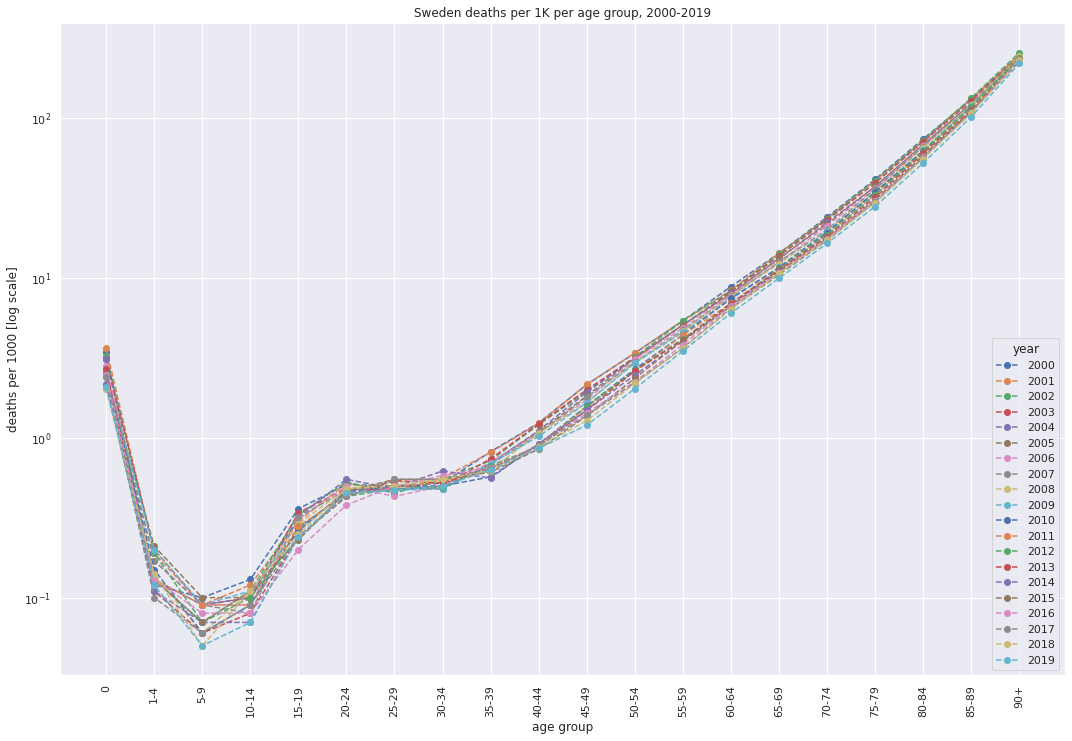

In [11]:
# Darwin awards to young males.....

# max deathrate and corresponding column index 

print(death_rate.max(axis=1),death_rate.apply(lambda row: np.argmax(row),axis=1))

death_rate.plot(figsize=(18,12),style='o--',title='Sweden deaths per 1K per age group, 2000-2019')
plt.xlabel('age group')
plt.ylabel('deaths per 1000 [log scale]')
plt.yscale('log')
_= plt.xticks(range(len(death_rate)),death_rate.index.values,rotation=90)

In [12]:
# fetch population data

url2 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data2 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "agg:Ålder5år",
        "values": [
          "-4",
          "5-9",
          "10-14",
          "15-19",
          "20-24",
          "25-29",
          "30-34",
          "35-39",
          "40-44",
          "45-49",
          "50-54",
          "55-59",
          "60-64",
          "65-69",
          "70-74",
          "75-79",
          "80-84",
          "85-89",
          "90-94",
          "95-99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2000",
          "2001",
          "2002",
          "2003",
          "2004",
          "2005",
          "2006",
          "2007",
          "2008",
          "2009",
          "2010",
          "2011",
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}


In [13]:
r2 = requests.post(url2,json=data2)
print (r2.status_code)
json2 = r2.json()

200


In [14]:
#parse population data

data_list2 = []

nr_records2 = (len(json2['data']))

for rec2 in range(nr_records2):

    data_list2.append ((json2['data'][rec2]['key'][0],
                        json2['data'][rec2]['key'][1],json2['data'][rec2]['key'][2],json2['data'][rec2]['values'][0]))


In [15]:
# put pop.data into df2

population = pd.DataFrame(data_list2,columns=['age_grp','gender','year','pop'])
population['year'] = population['year'].astype(int)
population['pop'] = population['pop'].astype(int)



In [16]:
# make age_grp categorical for correct sort order
population['age_grp'] = pd.Categorical(population['age_grp'],['-4','5-9','10-14','15-19','20-24','25-29',
                                               '30-34','35-39','40-44','45-49','50-54',
                                               '55-59','60-64','65-69','70-74','75-79',
                                               '80-84','85-89','90-94','95-99','100+'])

population

,age_grp,gender,year,pop
0,-4,1,2000,234890
1,-4,1,2001,234235
2,-4,1,2002,237592
3,-4,1,2003,242795
4,-4,1,2004,249343
...,...,...,...,...
835,100+,2,2015,1581
836,100+,2,2016,1649
837,100+,2,2017,1732
838,100+,2,2018,1705


In [17]:
# sum male + female by grouping 
population = population.groupby(['age_grp','year']).sum()
population = population.unstack()
population = population.droplevel(0,axis=1)

population_idx = ['1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90-94','95-99','100+']

population.index = population_idx
population

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1-4,457850,455767,462499,472886,485558,496345,512583,525305,536982,548222,561788,567369,573583,579019,584157,586218,597041,602044,604498,601718
5-9,585912,557400,527036,501599,479919,468687,468021,476238,488735,503934,515657,530937,543993,557950,571614,589118,600853,612180,619473,624084
10-14,587036,607108,622390,624505,618104,595744,568983,540190,516685,497286,487514,485964,494283,509132,526262,541807,563100,580453,595758,609019
15-19,508580,519061,532226,553300,574697,598380,619722,637028,641408,638533,618605,592376,564627,543627,527236,522472,529612,544838,559513,568909
20-24,516722,515633,517004,520017,522312,527268,541577,557526,580335,605453,632016,650862,667153,671940,671529,656448,640179,616919,597593,587699
25-29,592158,580920,568748,555951,545719,544061,547734,554452,562889,571759,581923,595136,609060,631255,655755,682413,711687,734003,741322,739696
30-34,627790,619124,611611,609103,612637,610276,602045,593201,585237,580069,581869,585111,591487,599989,609378,619071,641176,662493,690141,715891
35-39,632088,651076,664918,665896,651152,638015,631447,626492,626711,634498,633882,625948,616777,608912,604368,608570,617317,628193,640119,650598
40-44,584563,583214,586350,596567,615765,636164,656262,671687,674250,663060,652226,645713,640696,641199,650114,651944,647816,641675,635836,631263
45-49,583580,585599,586474,584872,586438,584853,584445,588628,600199,621146,642527,662411,677490,681129,670744,662423,658991,656677,658339,667092


In [18]:
population.sum()


year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
dtype: int64

In [19]:
# in order to compare with death rates, where 0-year old are separate, and highest cat is 90+,
# must do some restructruring of age groups

In [20]:
# new index to confirm with death rates

population_idx = ['1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90+']

# merge the 90-94,95-99 and 100+ groups to 90+

pop_90_plus = population.iloc[-3:].sum()
population = population.drop(['90-94','95-99','100+'])
population = population.append(pop_90_plus,ignore_index=True)
population.index = population_idx


In [21]:
# born under the year - find the 0-years old

url3 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101H/FoddaK'

data3 = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": []
      }
    },
    {
      "code": "AlderModer",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2000",
          "2001",
          "2002",
          "2003",
          "2004",
          "2005",
          "2006",
          "2007",
          "2008",
          "2009",
          "2010",
          "2011",
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [22]:
r3 = requests.post(url3,json=data3)
print (r3.status_code)
json3 = r3.json()

200


In [23]:
#parse population data

data_list3 = []

nr_records3 = (len(json3['data']))

for rec3 in range(nr_records3):

    data_list3.append ((json3['data'][rec3]['key'][0],
                        json3['data'][rec3]['key'][1],json3['data'][rec3]['values'][0]))


In [24]:
# put pop.data into df2

births = pd.DataFrame(data_list3,columns=['gender','year','0'])
births['year'] = births['year'].astype(int)
births['0'] = births['0'].astype(int)

births

,gender,year,0
0,1,2000,46620
1,1,2001,47138
2,1,2002,49187
3,1,2003,51114
4,1,2004,51975
5,1,2005,52036
6,1,2006,54483
7,1,2007,55259
8,1,2008,56352
9,1,2009,57564


In [25]:
# add boys + girls

births = (births.groupby(['year']).sum()).T
births.index.name='age_grp'
births

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
age_grp,,,,,,,,,,,,,,,,,,,,
0,90441,91466,95815,99157,100928,101346,105913,107421,109301,111801,115641,111770,113177,113593,114907,114870,117425,115416,115832,114523


In [26]:
# add zero years old to top of population, subtract z-years from 1-4
population = pd.concat([births,population],axis=0)
population.loc['1-4',:] = population.loc['1-4',:] - population.loc['0',:]
population


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,90441,91466,95815,99157,100928,101346,105913,107421,109301,111801,115641,111770,113177,113593,114907,114870,117425,115416,115832,114523
1-4,367409,364301,366684,373729,384630,394999,406670,417884,427681,436421,446147,455599,460406,465426,469250,471348,479616,486628,488666,487195
5-9,585912,557400,527036,501599,479919,468687,468021,476238,488735,503934,515657,530937,543993,557950,571614,589118,600853,612180,619473,624084
10-14,587036,607108,622390,624505,618104,595744,568983,540190,516685,497286,487514,485964,494283,509132,526262,541807,563100,580453,595758,609019
15-19,508580,519061,532226,553300,574697,598380,619722,637028,641408,638533,618605,592376,564627,543627,527236,522472,529612,544838,559513,568909
20-24,516722,515633,517004,520017,522312,527268,541577,557526,580335,605453,632016,650862,667153,671940,671529,656448,640179,616919,597593,587699
25-29,592158,580920,568748,555951,545719,544061,547734,554452,562889,571759,581923,595136,609060,631255,655755,682413,711687,734003,741322,739696
30-34,627790,619124,611611,609103,612637,610276,602045,593201,585237,580069,581869,585111,591487,599989,609378,619071,641176,662493,690141,715891
35-39,632088,651076,664918,665896,651152,638015,631447,626492,626711,634498,633882,625948,616777,608912,604368,608570,617317,628193,640119,650598
40-44,584563,583214,586350,596567,615765,636164,656262,671687,674250,663060,652226,645713,640696,641199,650114,651944,647816,641675,635836,631263


In [27]:
# check for correct totals

population.sum()

year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
dtype: int64

In [28]:
#yby_pop_increase = population.sum() / (population.sum()).shift()
#yby_pop_increase
yby_age_increase = population.T / population.T.shift()
yby_age_increase


,0,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
year,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,1.011333,0.991541,0.951337,1.034192,1.020608,0.997892,0.981022,0.986196,1.030040,0.997692,1.003460,0.971525,1.054494,1.028476,1.005340,0.989930,0.973828,1.035918,1.006681,1.027958
2002,1.047548,1.006541,0.945526,1.025172,1.025363,1.002659,0.979047,0.987865,1.021260,1.005377,1.001494,0.975545,1.029075,1.049886,1.011079,0.994649,0.982139,1.012367,1.004455,1.022630
2003,1.034880,1.019213,0.951736,1.003398,1.039596,1.005828,0.977500,0.995899,1.001471,1.017425,0.997268,0.978275,1.010765,1.059222,1.029090,0.982850,0.987552,1.013622,1.006140,1.029296
2004,1.017861,1.029168,0.956778,0.989750,1.038672,1.004413,0.981596,1.005802,0.977858,1.032181,1.002678,0.980458,0.991145,1.064042,1.034298,0.993710,0.985325,1.009457,1.011123,1.033015
2005,1.004142,1.026958,0.976596,0.963825,1.041210,1.009489,0.996962,0.996146,0.979825,1.033128,0.997297,0.991830,0.981011,1.064622,1.026910,0.993745,0.991674,0.975681,1.069973,1.016803
2006,1.045063,1.029547,0.998579,0.955080,1.035666,1.027138,1.006751,0.986513,0.989706,1.031592,0.999302,1.004279,0.972045,1.055064,1.029251,1.008031,0.993258,0.979130,1.045296,1.020671
2007,1.014238,1.027575,1.017557,0.949396,1.027925,1.029449,1.012265,0.985310,0.992153,1.023504,1.007157,1.002592,0.976185,1.029518,1.050703,1.014450,0.997728,0.987625,1.015655,1.017607
2008,1.017501,1.023444,1.026241,0.956488,1.006876,1.040911,1.015217,0.986575,1.000350,1.003816,1.019658,0.998744,0.979347,1.011492,1.060145,1.031874,0.986750,0.991758,1.019423,1.013571


In [29]:
max_age_increase = yby_age_increase.max(axis=1)
max_age_increase_idx =yby_age_increase.apply(np.argmax,axis=1)


In [30]:
age_increase_2019 = yby_age_increase.loc[2019]
age_increase_2019

0        0.988699
1-4      0.996990
5-9      1.007443
10-14    1.022259
15-19    1.016793
20-24    0.983444
25-29    0.997807
30-34    1.037311
35-39    1.016370
40-44    0.992808
45-49    1.013296
50-54    0.985325
55-59    1.035296
60-64    1.005882
65-69    0.983137
70-74    0.994264
75-79    1.069839
80-84    1.044060
85-89    1.008170
90+      1.013469
Name: 2019, dtype: float64

In [31]:
### ASSUME population for 2020 increases by age group as it did from 2018 to 2019
pop_2020 = population[2019] * age_increase_2019
population[2020] = pop_2020.astype(int)
#population
population.sum()

year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
2020    10430517
dtype: int64

In [32]:
medel_pop = (population.T + population.T.shift()) / 2 #snittet av två påföljande år
medel_pop = medel_pop.T
medel_pop = medel_pop.drop(2000,axis=1)

# use the official population average of two consequtive years; drop column 2000 in death rate also

#### CHANGING POPULATION to official AVERAGE population! 
population = medel_pop
####

death_rate = death_rate.drop(2000,axis=1)

In [33]:
population.sum()

year
2001     8895960.0
2002     8924958.0
2003     8958229.0
2004     8993531.0
2005     9029572.0
2006     9080504.5
2007     9148092.0
2008     9219637.0
2009     9298514.5
2010     9378126.0
2011     9449212.5
2012     9519374.0
2013     9600378.5
2014     9696109.5
2015     9799186.0
2016     9923085.0
2017    10057697.5
2018    10175213.5
2019    10278887.0
2020    10379053.0
dtype: float64

<AxesSubplot:xlabel='year'>

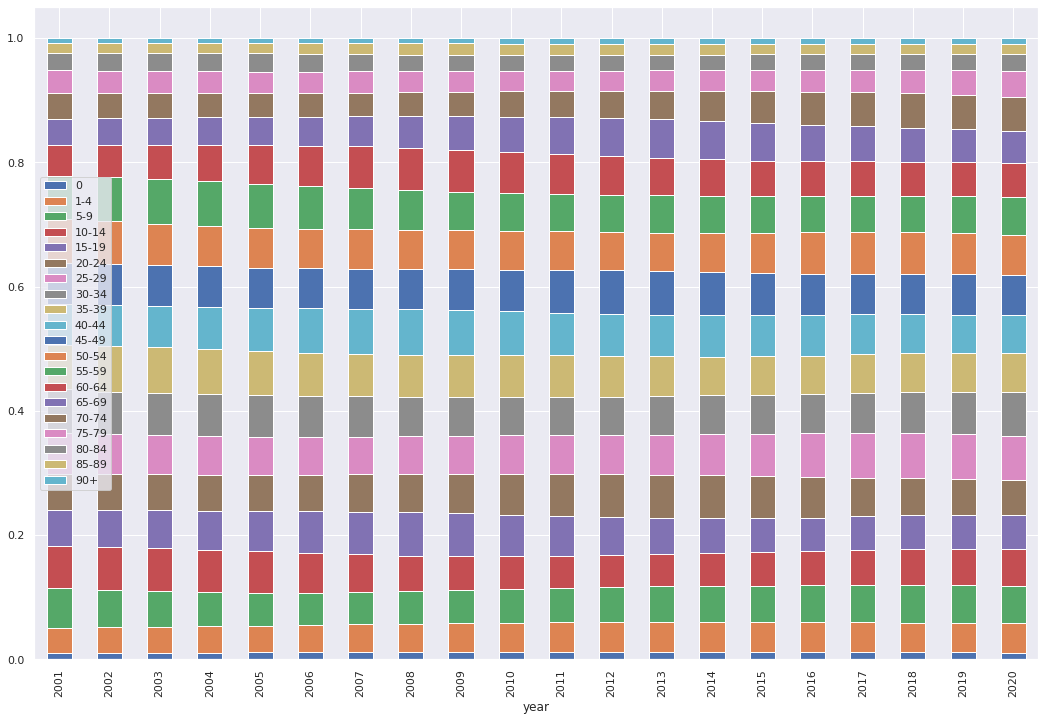

In [34]:
(population / population.sum()).T.plot(kind='bar',stacked=True,figsize=(18,12))

In [35]:
# table taken from scb excel sheet 2
# to get 2020 deaths

age_df = pd.read_csv('scb_dead_per_age.csv',sep=';',header=None,usecols=range(19),index_col=0)

cols = ['2019_tot','2019_M_64','2019_M_79','2019_M_89','2019_M_90+',
       '2019_W_64','2019_W_79','2019_W_89','2019_W_90+',
       '2020_tot','2020_M_64','2020_M_79','2020_M_89','2020_M_90+',
       '2020_W_64','2020_W_79','2020_W_89','2020_W_90+']

index = pd.date_range('2020-01-01','2021-01-01')
age_df.index = index
age_df.columns = cols
age_df

,2019_tot,2019_M_64,2019_M_79,2019_M_89,2019_M_90+,2019_W_64,2019_W_79,2019_W_89,2019_W_90+,2020_tot,2020_M_64,2020_M_79,2020_M_89,2020_M_90+,2020_W_64,2020_W_79,2020_W_89,2020_W_90+
2020-01-01,300,20,48,56,32,12,39,46,47,254,14,40,47,16,16,30,50,41
2020-01-02,276,25,33,48,24,13,28,57,48,300,20,49,36,29,13,47,51,55
2020-01-03,271,13,41,48,22,9,38,49,51,256,13,26,49,23,2,35,47,61
2020-01-04,282,17,48,52,28,14,39,57,27,272,14,37,43,21,15,40,45,57
2020-01-05,275,21,37,52,28,11,34,52,40,265,10,41,49,18,9,38,46,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,215,15,50,23,18,10,20,43,36,0,0,0,0,0,0,0,0,0
2020-12-29,244,11,50,52,20,7,23,44,37,0,0,0,0,0,0,0,0,0
2020-12-30,226,15,39,41,21,12,31,29,38,0,0,0,0,0,0,0,0,0
2020-12-31,246,22,43,39,22,12,32,41,35,0,0,0,0,0,0,0,0,0


In [36]:
monthly = age_df.resample('M').sum()
monthly

,2019_M_64,2019_M_79,2019_M_89,2019_M_90+,2019_W_64,2019_W_79,2019_W_89,2019_W_90+,2020_M_64,2020_M_79,2020_M_89,2020_M_90+,2020_W_64,2020_W_79,2020_W_89,2020_W_90+
2020-01-31,540,1340,1421,760,340,982,1461,1330,494,1297,1417,754,328,1003,1442,1385
2020-02-29,488,1230,1249,602,274,876,1329,1246,438,1202,1330,661,316,895,1306,1217
2020-03-31,462,1280,1319,628,307,973,1319,1282,496,1400,1528,718,348,1007,1473,1395
2020-04-30,438,1172,1247,630,305,857,1321,1216,618,1747,1938,946,318,1179,1916,1708
2020-05-31,420,1168,1173,597,307,872,1255,1180,556,1471,1523,796,312,1013,1596,1433
2020-06-30,439,1134,1044,539,287,833,1132,1044,492,1232,1295,621,284,868,1254,1179
2020-07-31,443,1170,1098,565,290,909,1208,1040,454,1170,1182,575,297,878,1189,1072
2020-08-31,428,1142,1170,576,298,821,1242,1152,230,647,700,319,168,481,691,609
2020-09-30,431,1207,1171,561,317,800,1169,1018,0,0,0,0,0,0,0,0
2020-10-31,428,1282,1281,690,345,916,1227,1169,0,0,0,0,0,0,0,0


In [37]:

monthly.sum()



2019_M_64      6161
2019_M_79     15312
2019_M_89     15040
2019_M_90+     7513
2019_W_64      3978
2019_W_79     10967
2019_W_89     15554
2019_W_90+    14241
2020_M_64      4238
2020_M_79     10650
2020_M_89     11053
2020_M_90+     5412
2020_W_64      2515
2020_W_79      7521
2020_W_89     10981
2020_W_90+    10042
dtype: int64

In [38]:



#monthly.drop(['2019_tot','2020_tot'],axis=1,inplace=True)
monthly_sums_per_age = monthly.sum()
cols = ['2019_M_64','2020_M_64','2019_M_79','2020_M_79','2019_M_89','2020_M_89','2019_M_90+','2020_M_90+',
        '2019_W_64','2020_W_64','2019_W_79','2020_W_79','2019_W_89','2020_W_89','2019_W_90+','2020_W_90+']

monthly_sums_per_age = monthly_sums_per_age[cols]

foo = monthly_sums_per_age.index.str.contains('W')

monthly_sums_per_age = pd.DataFrame(monthly_sums_per_age,columns=['dead'])


monthly_sums_per_age['female'] = foo


monthly_sums_per_age.reset_index(inplace=True,drop=False)

bar = monthly_sums_per_age['index'].str[-3:].str.replace('_','').str.replace('+','').astype(int)

monthly_sums_per_age['age'] = bar

monthly_sums_per_age['year'] = monthly_sums_per_age['index'].apply(lambda x : x[:4])
monthly_sums_per_age['year'] = monthly_sums_per_age['year'].apply(lambda x : pd.Timestamp(x).year)
monthly_sums_per_age['gender'] = monthly_sums_per_age['female'].apply(lambda x : 'F' if x == True else 'M')
monthly_sums_per_age.index = monthly_sums_per_age[['year','gender','age']]

monthly_sums_per_age = monthly_sums_per_age.groupby(['year','age'])['dead'].sum()
deaths_2020_ytd = monthly_sums_per_age.unstack()
deaths_2020_ytd = deaths_2020_ytd.drop(2019).T

deaths_2020_ytd = deaths_2020_ytd * ( 1 / year_fraction)
print (deaths_2020_ytd)
print (deaths_2020_ytd.sum())

year          2020
age               
64    10562.384615
79    28421.307692
89    34463.435897
90    24171.641026
year
2020    97618.769231
dtype: float64


In [39]:
# CALCULATE ABSOLUTE YEARLY DEATHS FROM POPULATION x DEATH RATE - 2020 forecasted 
absolute_deaths = (death_rate / 1000 * population).astype(int,errors='ignore')
print (absolute_deaths.sum())


year
2001    93740.0
2002    94982.0
2003    92951.0
2004    90524.0
2005    91697.0
2006    91153.0
2007    91716.0
2008    91434.0
2009    90052.0
2010    90473.0
2011    89932.0
2012    91931.0
2013    90383.0
2014    88968.0
2015    90913.0
2016    90968.0
2017    91960.0
2018    92182.0
2019    88763.0
2020        0.0
dtype: float64


In [40]:
# stratify absolute deaths into 4 age groups

abs_deaths_64 = absolute_deaths.loc[:'60-64'].sum()
abs_deaths_79 = absolute_deaths.loc['65-69' : '75-79'].sum()
abs_deaths_89 = absolute_deaths.loc['80-84': '85-89'].sum()
abs_deaths_90 = absolute_deaths.loc['90+']

strata_abs_deaths = pd.concat([abs_deaths_64,abs_deaths_79,abs_deaths_89,abs_deaths_90],axis=1)
strata_abs_deaths.columns = ['64','79','89','90+']

strata_abs_deaths.loc[2020,:] = deaths_2020_ytd.T.values

strata_abs_deaths = strata_abs_deaths.astype(int)
print (strata_abs_deaths.sum(axis=1))
strata_abs_deaths

year
2001    93740
2002    94982
2003    92951
2004    90524
2005    91697
2006    91153
2007    91716
2008    91434
2009    90052
2010    90473
2011    89932
2012    91931
2013    90383
2014    88968
2015    90913
2016    90968
2017    91960
2018    92182
2019    88763
2020    97617
dtype: int64


,64,79,89,90+
year,,,,
2001,13260,27435,36600,16445
2002,13098,26994,37507,17383
2003,13085,26097,36751,17018
2004,13057,24865,35692,16910
2005,13095,24758,36190,17654
2006,13033,24041,36080,17999
2007,12937,23763,36350,18666
2008,12848,23500,36200,18886
2009,12554,23450,35430,18618


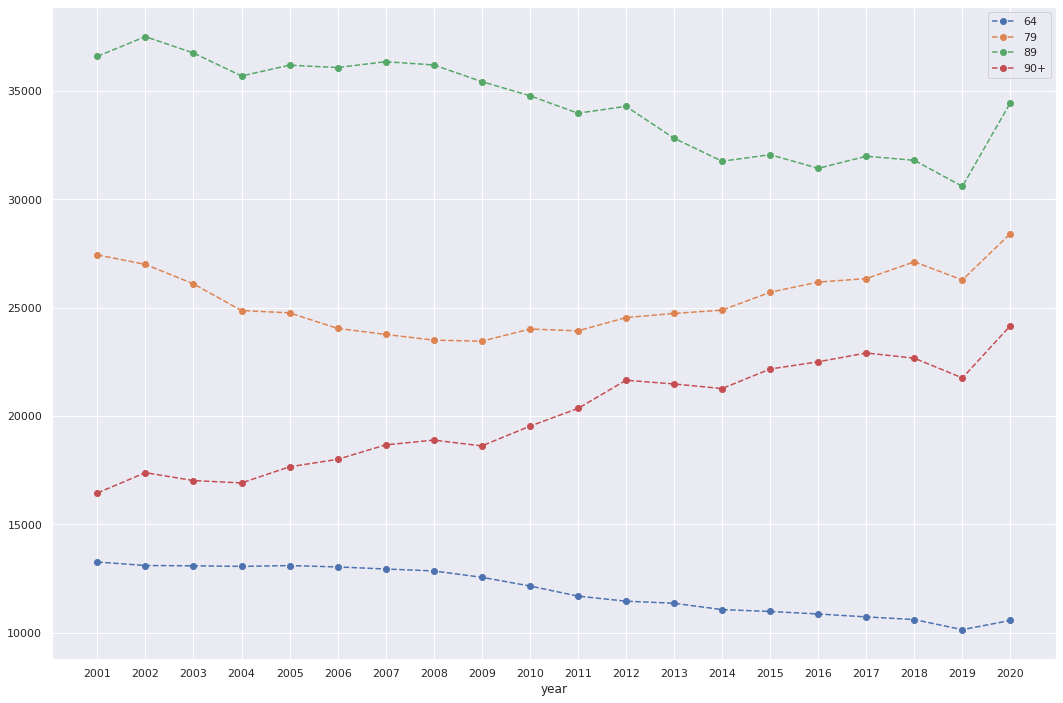

In [41]:
strata_abs_deaths.plot(figsize=(18,12),style='o--')
_= plt.xticks(range(2001,2021))

In [42]:
# stratify population to 4 age groups

abs_pop_64 = population.loc[:'60-64'].sum()
abs_pop_79 = population.loc['65-69' : '75-79'].sum()
abs_pop_89 = population.loc['80-84' : '85-89'].sum()
abs_pop_90 = population.loc['90+']

strata_abs_pop = pd.concat([abs_pop_64,abs_pop_79,abs_pop_89,abs_pop_90],axis=1)
strata_abs_pop.columns = ['64','79','89','90+']
strata_abs_pop

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0
2006,7507097.5,1084698.5,413877.0,74831.5
2007,7553167.0,1104317.0,414345.5,76262.5
2008,7592890.0,1134709.5,414587.5,77450.0
2009,7630585.5,1174180.0,414772.5,78976.5


In [43]:
strata_abs_pop.sum(axis=1)

year
2001     8895960.0
2002     8924958.0
2003     8958229.0
2004     8993531.0
2005     9029572.0
2006     9080504.5
2007     9148092.0
2008     9219637.0
2009     9298514.5
2010     9378126.0
2011     9449212.5
2012     9519374.0
2013     9600378.5
2014     9696109.5
2015     9799186.0
2016     9923085.0
2017    10057697.5
2018    10175213.5
2019    10278887.0
2020    10379053.0
dtype: float64

In [44]:
# compute stratified per capita death rates

computed_death_rate_per_capita = strata_abs_deaths / strata_abs_pop
computed_death_rate_per_capita 


,64,79,89,90+
year,,,,
2001,0.001801,0.025566,0.093294,0.248865
2002,0.001772,0.025321,0.093974,0.256579
2003,0.001763,0.024509,0.091143,0.244826
2004,0.001754,0.023268,0.087596,0.235916
2005,0.001753,0.023028,0.087990,0.240341
2006,0.001736,0.022164,0.087176,0.240527
2007,0.001713,0.021518,0.087729,0.244760
2008,0.001692,0.020710,0.087316,0.243848
2009,0.001645,0.019971,0.085420,0.235741


In [45]:
computed_death_rate_per_capita / computed_death_rate_per_capita.loc[2015:2019].mean()

,64,79,89,90+
year,,,,
2001,1.359619,1.435905,1.225164,1.080824
2002,1.338004,1.422138,1.234094,1.114328
2003,1.331510,1.376519,1.196917,1.063284
2004,1.324194,1.306792,1.150337,1.024587
2005,1.323785,1.293364,1.155508,1.043804
2006,1.310957,1.244801,1.144811,1.044612
2007,1.293363,1.208548,1.152074,1.062996
2008,1.277746,1.163160,1.146651,1.059034
2009,1.242339,1.121669,1.121760,1.023827


<AxesSubplot:title={'center':'SWEDEN age group ratio of population'}, xlabel='year'>

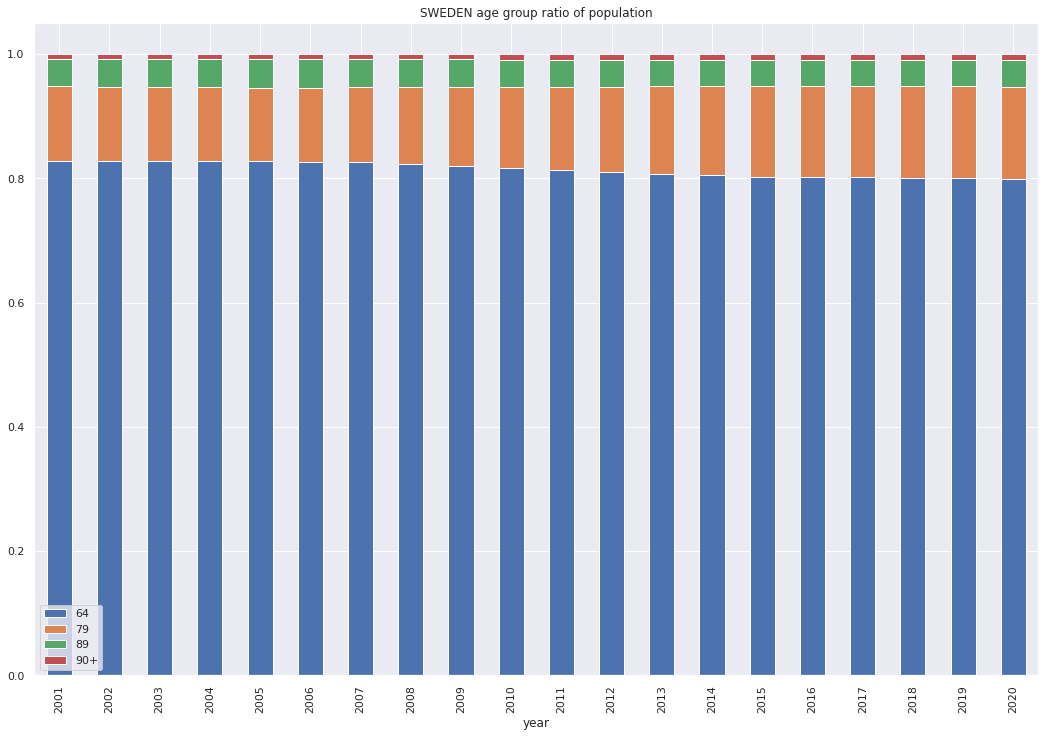

In [46]:
(strata_abs_pop.div(strata_abs_pop.sum(axis=1),axis=0)).plot(kind='bar',title='SWEDEN age group ratio of population',
                                                             stacked=True,figsize=(18,12))

In [47]:
# death rate YBY change

stratified_yearly_death_rate_per_capita_YBY_change = computed_death_rate_per_capita / computed_death_rate_per_capita.shift()
stratified_yearly_death_rate_per_capita_YBY_change

,64,79,89,90+
year,,,,
2001,NaN,NaN,NaN,NaN
2002,0.984102,0.990412,1.007288,1.030998
2003,0.995147,0.967922,0.969876,0.954193
2004,0.994505,0.949346,0.961083,0.963606
2005,0.999691,0.989724,1.004495,1.018755
2006,0.990309,0.962452,0.990743,1.000775
2007,0.986580,0.970877,1.006344,1.017598
2008,0.987925,0.962444,0.995292,0.996273
2009,0.972290,0.964328,0.978293,0.966755


In [48]:
# calculate avg 2015-2019 death rate

stratified_avg_death_rate_2015_2019 = computed_death_rate_per_capita.loc[2015:2019].mean()
stratified_avg_death_rate_2015_2019

64     0.001324
79     0.017805
89     0.076148
90+    0.230255
dtype: float64

In [49]:
# factor death yearly death rates vs avg 2015-2019

stratified_death_rate_vs_avg_2015_2019 = computed_death_rate_per_capita / stratified_avg_death_rate_2015_2019

stratified_death_rate_vs_avg_2015_2019

,64,79,89,90+
year,,,,
2001,1.359619,1.435905,1.225164,1.080824
2002,1.338004,1.422138,1.234094,1.114328
2003,1.331510,1.376519,1.196917,1.063284
2004,1.324194,1.306792,1.150337,1.024587
2005,1.323785,1.293364,1.155508,1.043804
2006,1.310957,1.244801,1.144811,1.044612
2007,1.293363,1.208548,1.152074,1.062996
2008,1.277746,1.163160,1.146651,1.059034
2009,1.242339,1.121669,1.121760,1.023827


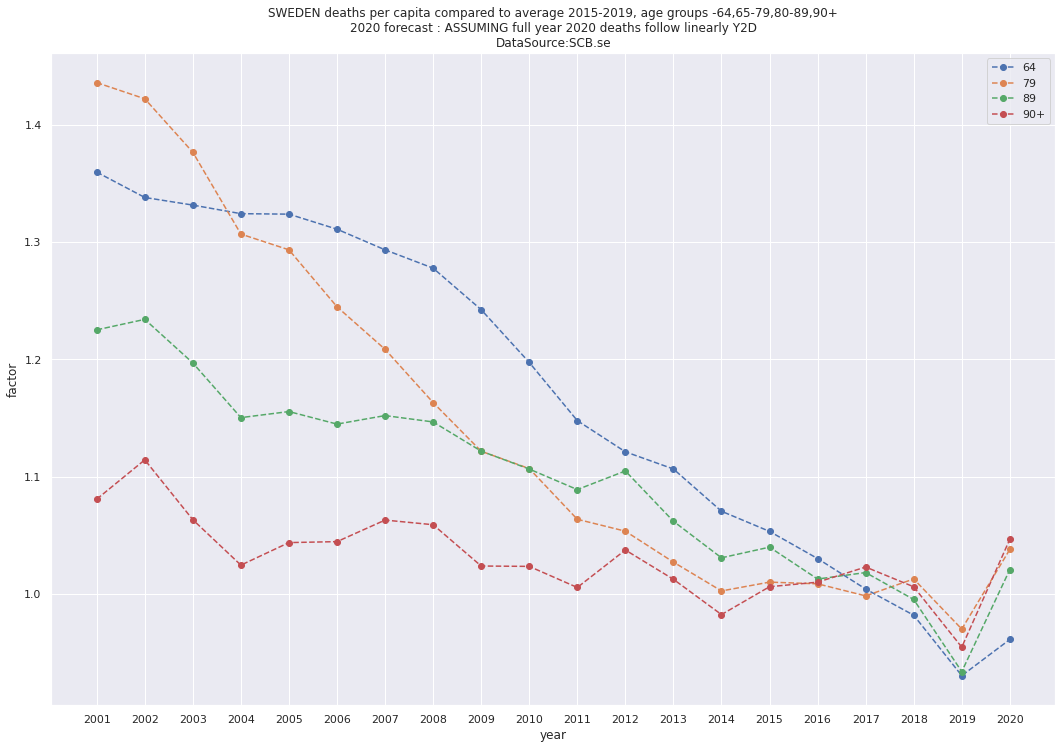

In [50]:
title = 'SWEDEN deaths per capita compared to average 2015-2019, age groups -64,65-79,80-89,90+\n'\
'2020 forecast : ASSUMING full year 2020 deaths follow linearly Y2D\nDataSource:SCB.se'

stratified_death_rate_vs_avg_2015_2019.plot(figsize=(18,12),
                                            style='o--',title=title)
plt.xticks(range(2001,2021))
plt.ylabel('factor')
plt.savefig('death_rate_trend.jpg',format='jpg')

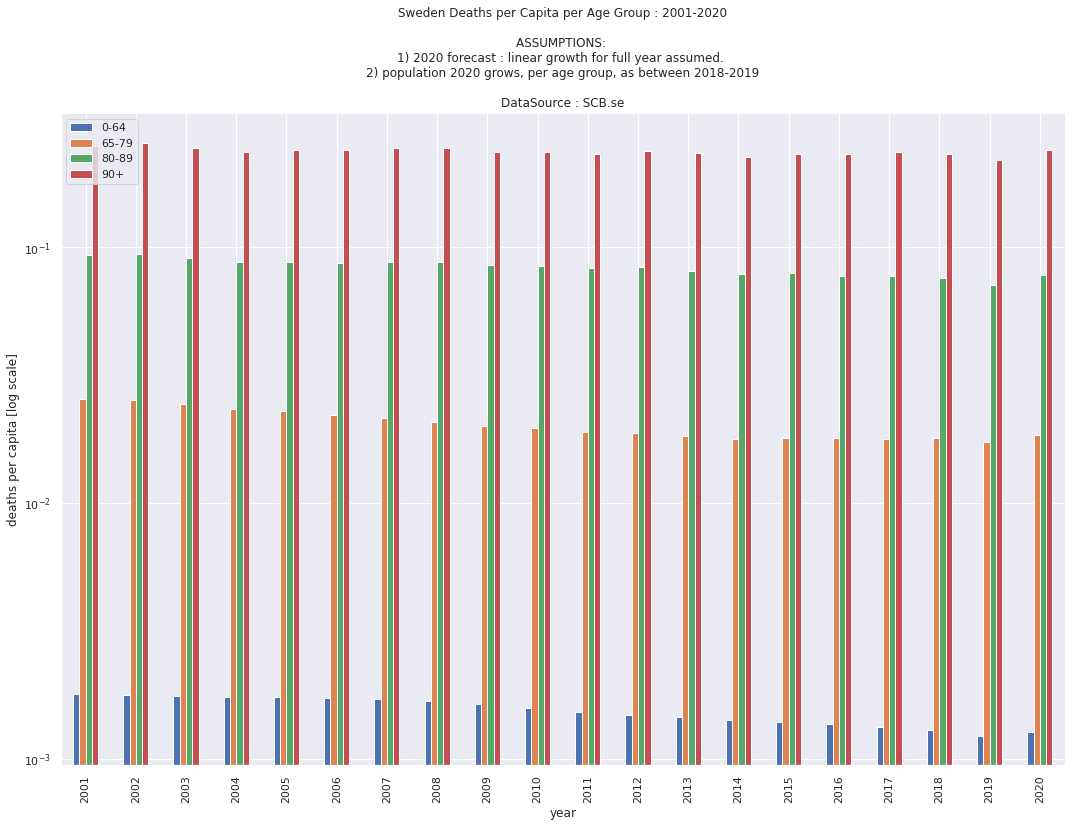

In [51]:
title = 'Sweden Deaths per Capita per Age Group : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) 2020 forecast : linear growth for full year assumed. \n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'

(computed_death_rate_per_capita).plot(kind='bar',
                                    figsize=(18,12),
                                      title=title)
plt.yscale('log')
plt.ylabel('deaths per capita [log scale]')
plt.legend(['0-64','65-79','80-89','90+'])
plt.savefig('age_adj_death_ratio_1.jpg',format='jpg')


In [52]:
per_M_ylim = [0,14000]

            64        79        89       90+
year                                        
2001  0.001801  0.025566  0.093294  0.248865
2002  0.001772  0.025321  0.093974  0.256579
2003  0.001763  0.024509  0.091143  0.244826
2004  0.001754  0.023268  0.087596  0.235916
2005  0.001753  0.023028  0.087990  0.240341
2006  0.001736  0.022164  0.087176  0.240527
2007  0.001713  0.021518  0.087729  0.244760
2008  0.001692  0.020710  0.087316  0.243848
2009  0.001645  0.019971  0.085420  0.235741
2010  0.001586  0.019708  0.084257  0.235669
2011  0.001520  0.018939  0.082925  0.231529
2012  0.001485  0.018758  0.084134  0.238885
2013  0.001465  0.018289  0.080868  0.233133
2014  0.001418  0.017851  0.078496  0.226210
2015  0.001395  0.017985  0.079187  0.231680
2016  0.001364  0.017959  0.077118  0.232569
2017  0.001330  0.017776  0.077539  0.235544
2018  0.001300  0.018033  0.075792  0.231666
2019  0.001232  0.017273  0.071107  0.219815
2020  0.001273  0.018481  0.077731  0.240993


year
2001    93740.0
2002    94982.0
2003    92951.0
2004    90524.0
2005    91697.0
2006    91153.0
2007    91716.0
2008    91434.0
2009    90052.0
2010    90473.0
2011    89932.0
2012    91931.0
2013    90383.0
2014    88968.0
2015    90913.0
2016    90968.0
2017    91960.0
2018    92182.0
2019    88763.0
2020    97617.0
dtype: float64

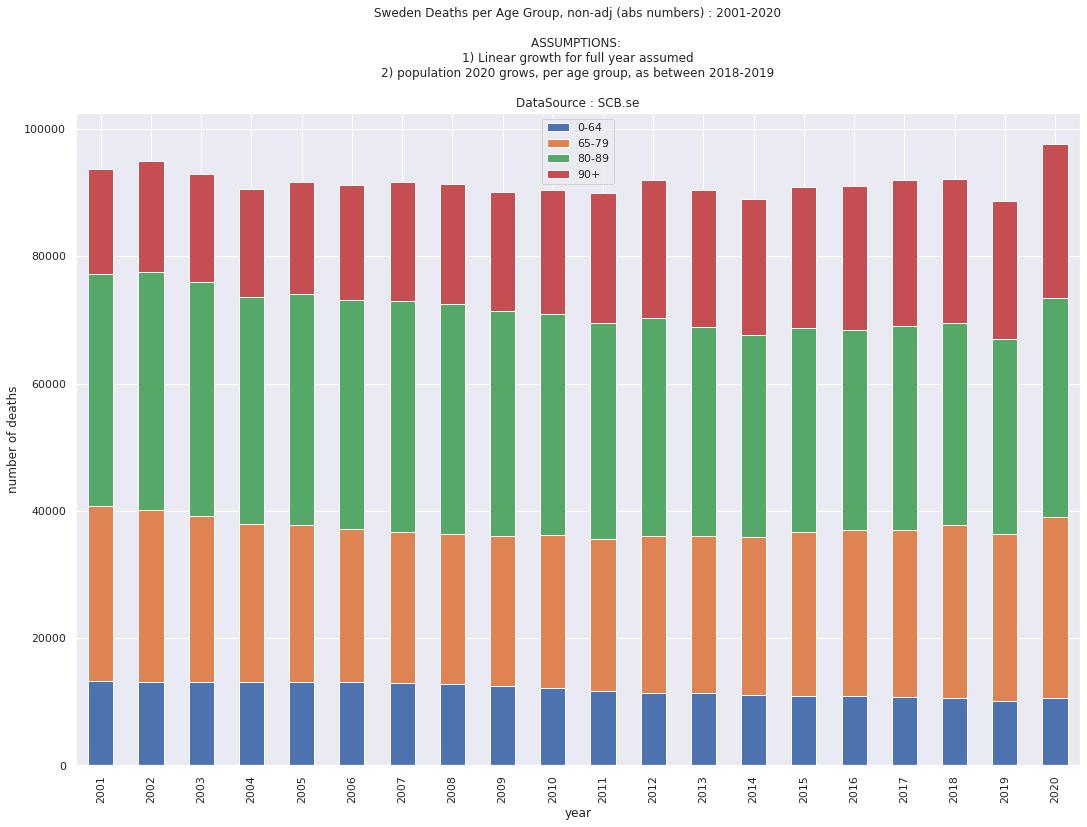

In [53]:
title = 'Sweden Deaths per Age Group, non-adj (abs numbers) : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'
print (computed_death_rate_per_capita)
total_computed_deaths = computed_death_rate_per_capita * strata_abs_pop
total_computed_deaths.plot(kind='bar',
                           stacked=True,figsize=(18,12),title=title)
plt.legend(['0-64','65-79','80-89','90+'])
plt.ylabel('number of deaths')
total_computed_deaths.sum(axis=1)
plt.savefig('age_adj_abs_numbers_age_grp_1.jpg',format='jpg',dpi=600)
total_computed_deaths.sum(axis=1)


In [54]:
tot_abs_deaths = total_computed_deaths.sum(axis=1)
mean_2010_2018 = tot_abs_deaths.loc['2010':'2018'].mean()
tot_abs_deaths

year
2001    93740.0
2002    94982.0
2003    92951.0
2004    90524.0
2005    91697.0
2006    91153.0
2007    91716.0
2008    91434.0
2009    90052.0
2010    90473.0
2011    89932.0
2012    91931.0
2013    90383.0
2014    88968.0
2015    90913.0
2016    90968.0
2017    91960.0
2018    92182.0
2019    88763.0
2020    97617.0
dtype: float64

In [55]:
dead_per_M_strata = (total_computed_deaths / strata_abs_pop * 1e6).astype(int)
dead_per_M_strata

,64,79,89,90+
year,,,,
2001,1800,25566,93294,248865
2002,1771,25321,93974,256579
2003,1763,24509,91143,244826
2004,1753,23267,87596,235916
2005,1753,23028,87990,240340
2006,1736,22163,87175,240527
2007,1712,21518,87728,244759
2008,1692,20710,87315,243847
2009,1645,19971,85420,235741


In [56]:
std_pop = strata_abs_pop.loc[2010]
std_pop

64     7664114.5
79     1218367.0
89      412782.5
90+      82862.0
Name: 2010, dtype: float64

In [57]:
computed_death_rate_per_capita.to_pickle('computed_death_rate_per_capita.pkl')
computed_death_rate_per_capita

,64,79,89,90+
year,,,,
2001,0.001801,0.025566,0.093294,0.248865
2002,0.001772,0.025321,0.093974,0.256579
2003,0.001763,0.024509,0.091143,0.244826
2004,0.001754,0.023268,0.087596,0.235916
2005,0.001753,0.023028,0.087990,0.240341
2006,0.001736,0.022164,0.087176,0.240527
2007,0.001713,0.021518,0.087729,0.244760
2008,0.001692,0.020710,0.087316,0.243848
2009,0.001645,0.019971,0.085420,0.235741


In [58]:
age_adj_deaths = std_pop * computed_death_rate_per_capita
age_adj_deaths

,64,79,89,90+
year,,,,
2001,13799.493810,31149.232398,38510.296159,20621.452633
2002,13580.111565,30850.578717,38790.971695,21260.684970
2003,13514.207207,29860.957510,37622.422558,20286.798628
2004,13439.952250,28348.380682,36158.275829,19548.486565
2005,13435.795869,28057.075475,36320.797370,19915.127127
2006,13305.595708,27003.596895,35984.586242,19930.552481
2007,13127.029931,26217.159585,36212.880012,20281.292798
2008,12968.519641,25232.559082,36042.395152,20205.703447
2009,12609.162617,24332.475557,35260.013562,19533.971700


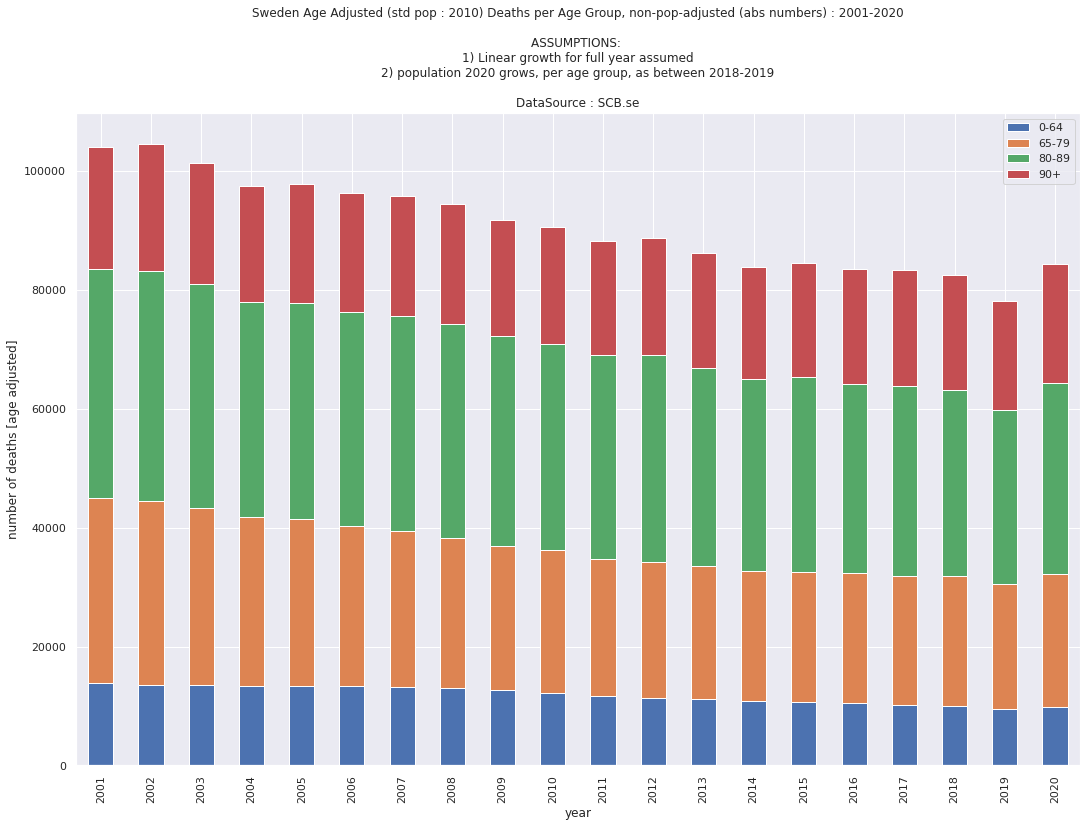

In [59]:
title = 'Sweden Age Adjusted (std pop : 2010) Deaths per Age Group, non-pop-adjusted (abs numbers) : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'
age_adj_deaths.plot(kind='bar',stacked=True,figsize=(18,12),title=title)
plt.legend(['0-64','65-79','80-89','90+'])
plt.ylabel('number of deaths [age adjusted]')
#plt.ylim([0,100000])
plt.savefig('age_adj_no_pop_adjusted_3.jpg',format='jpg',dpi=600)


In [60]:
print (std_pop.sum())
age_adj_deaths_per_M = age_adj_deaths.sum(axis=1) / (std_pop.sum() / 1e6)
age_adj_deaths_per_M

9378126.0


year
2001    11098.216744
2002    11141.068796
2003    10800.066655
2004    10396.010389
2005    10420.930135
2006    10260.507411
2007    10219.351108
2008    10071.220767
2009     9781.871499
2010     9647.236559
2011     9398.297126
2012     9464.306112
2013     9192.885455
2014     8931.451307
2015     9009.044526
2016     8897.368260
2017     8890.274879
2018     8788.337106
2019     8322.879186
2020     8991.914405
dtype: float64

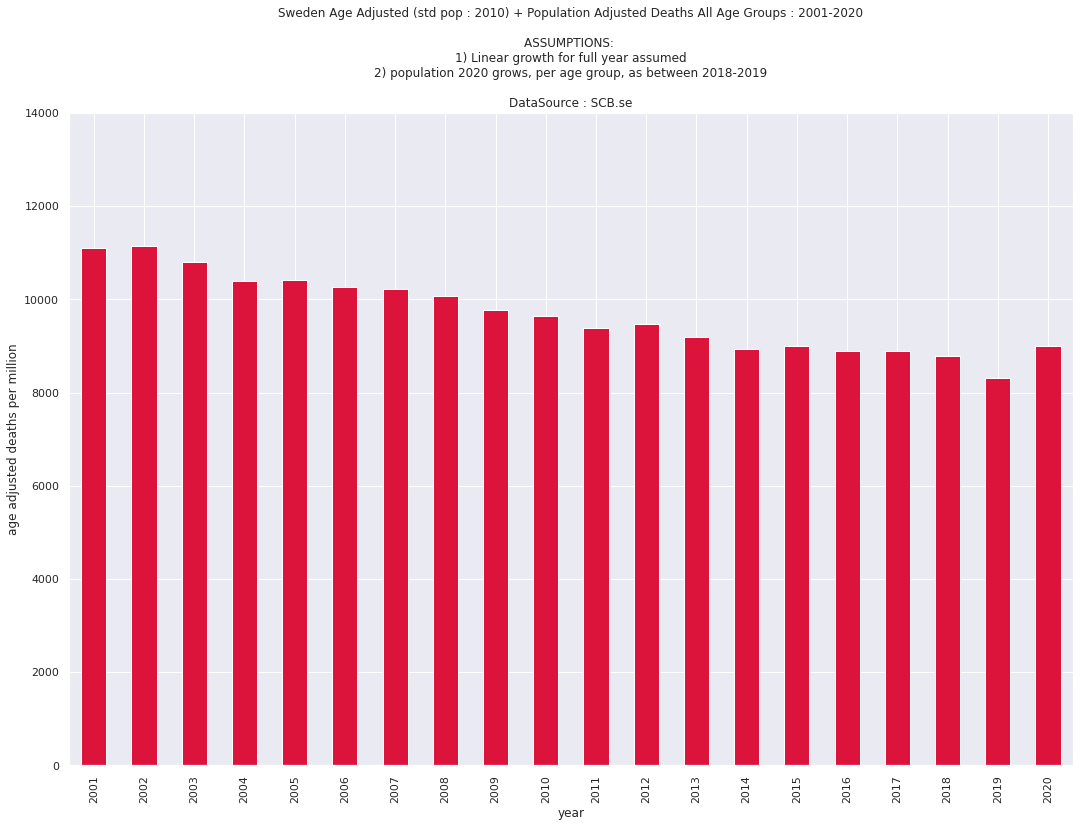

In [61]:
title = 'Sweden Age Adjusted (std pop : 2010) + Population Adjusted Deaths All Age Groups : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'

age_adj_deaths_per_M.plot(kind='bar',figsize=(18,12),title=title,color='crimson')
plt.ylabel('age adjusted deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('age_adj_pop_adj_4.jpg',format='jpg')


In [62]:
strata_abs_pop.head()

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0


In [63]:
def create_age_idx(a):
    if a == '64' : return 1
    if a == '79' : return 2
    if a == '89' : return 3
    if a == '90+' : return 4

all_data = strata_abs_pop.unstack().reset_index()
all_data.rename(columns={'level_0' : 'age_grp',0 : 'pop' },inplace=True)

temp = strata_abs_deaths.unstack().reset_index()

temp.rename(columns={'level_0' : 'age_grp', 0 : 'dead'},inplace=True)
all_data = pd.concat([all_data,temp['dead']],axis=1)
all_data['year_idx'] = all_data['year'] - 2000
all_data['age_idx'] = all_data['age_grp'].apply(create_age_idx)
all_data['pop'] = all_data['pop'].astype(int)
all_data.to_pickle('stratified_population_death_age_control.pkl')
all_data.tail(40)

,age_grp,year,pop,dead,year_idx,age_idx
40,89,2001,392306,36600,1,3
41,89,2002,399119,37507,2,3
42,89,2003,403221,36751,3,3
43,89,2004,407459,35692,4,3
44,89,2005,411296,36190,5,3
45,89,2006,413877,36080,6,3
46,89,2007,414345,36350,7,3
47,89,2008,414587,36200,8,3
48,89,2009,414772,35430,9,3
49,89,2010,412782,34780,10,3


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 30_000 tune and 50_000 draw iterations (60_000 + 100_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (84), generating only 20 plots
  warnings.warn(


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0]  -0.93  0.25   -1.20    -0.66       0.18     0.15       2.0     2.0   
alpha[1]  -0.93  0.25   -1.20    -0.66       0.18     0.15       2.0     2.0   
alpha[2]  -0.96  0.25   -1.23    -0.69       0.18     0.15       2.0     2.0   
alpha[3]  -1.00  0.25   -1.28    -0.74       0.18     0.15       2.0     2.0   
alpha[4]  -1.00  0.25   -1.28    -0.73       0.18     0.15       2.0     2.0   
...         ...   ...     ...      ...        ...      ...       ...     ...   
alpha[79] -1.80  4.37   -6.28     2.70       3.09     2.62       2.0     2.0   
beta[0]   -5.39  0.25   -5.65    -5.12       0.18     0.15       2.0     2.0   
beta[1]   -2.80  0.25   -3.06    -2.53       0.18     0.15       2.0     2.0   
beta[2]   -1.31  0.25   -1.58    -1.04       0.18     0.15       2.0     2.0   
beta[3]   -0.08  0.25   -0.34     0.20       0.18     0.15       2.0     2.0   

           ess_bulk  ess_tail  r_hat  


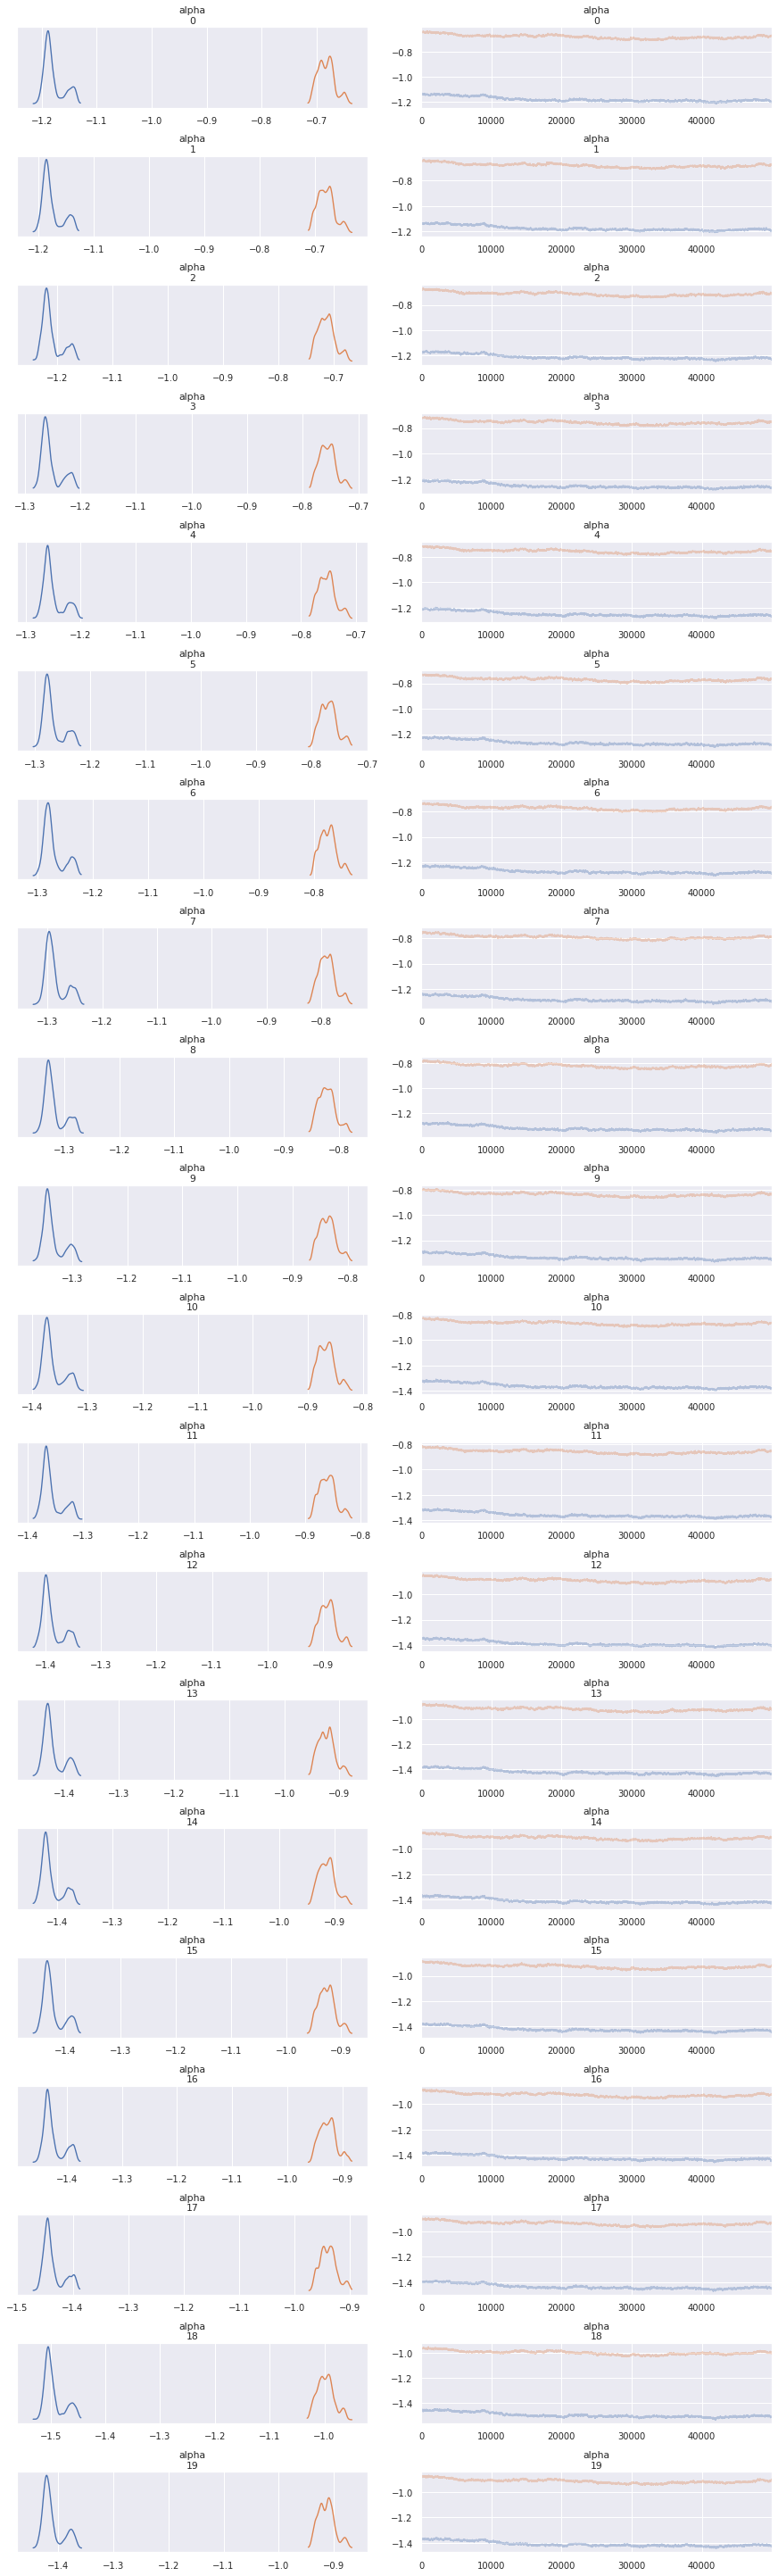

In [64]:
#PYMC
import pymc3 as pm
import arviz as az

#from pymc.Matplot import plot as pmplot


### condition on year by assigning a unique alpha to each year
### condition on age_grp by assigning a unique beta to each age group

# model: 
# dead ~ Binomial(population,p)
# p = logit(alpha[year_idx] + beta[age_idx])
# alpha[year_idx] ~ Normal(0,10)
# beta[age_idx] ~ Normal(0,10) 

model = pm.Model()

with model:
    year_idx = all_data['year_idx'] 
    age_idx = all_data['age_idx']

    alpha = pm.Normal('alpha',0, sigma=10,shape=len(year_idx)) # 20 years

    beta = pm.Normal('beta',0,sigma=10,shape=4)


    logit_age = np.exp(alpha[year_idx-1] + beta[age_idx-1]) / (
            1 + np.exp(alpha[year_idx-1] + beta[age_idx-1]))


    lkh_age = pm.Binomial('lkh_age',n=all_data['pop'],p=logit_age,observed=all_data['dead'])

    step1 = pm.Metropolis([alpha,beta])
    
    trace = pm.sample(50000,step1,tune=30000)
    _= az.plot_trace(trace)
    print (az.summary(trace,round_to=2))
    

In [65]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

In [66]:
#

alpha_2001 = trace['alpha'][:,0]
alpha_2002 = trace['alpha'][:,1]
alpha_2003 = trace['alpha'][:,2]
alpha_2004 = trace['alpha'][:,3]
alpha_2005 = trace['alpha'][:,4]
alpha_2006 = trace['alpha'][:,5]
alpha_2007 = trace['alpha'][:,6]
alpha_2008 = trace['alpha'][:,7]
alpha_2009 = trace['alpha'][:,8]
alpha_2010 = trace['alpha'][:,9]
alpha_2011 = trace['alpha'][:,10]
alpha_2012 = trace['alpha'][:,11]
alpha_2013 = trace['alpha'][:,12]
alpha_2014 = trace['alpha'][:,13]
alpha_2015 = trace['alpha'][:,14]
alpha_2016 = trace['alpha'][:,15]
alpha_2017 = trace['alpha'][:,16]
alpha_2018 = trace['alpha'][:,17]
alpha_2019 = trace['alpha'][:,18]
alpha_2020 = trace['alpha'][:,19]


beta_64 = trace['beta'][:,0]
beta_79 = trace['beta'][:,1]
beta_89 = trace['beta'][:,2]
beta_90 = trace['beta'][:,3]
'''
pmplot(beta_64,'beta_64')
pmplot(beta_79,'beta_79')
pmplot(beta_89,'beta_89')
pmplot(beta_90,'beta_90')

pmplot(alpha_2001,'alpha_2001')
pmplot(alpha_2002,'alpha_2002')
pmplot(alpha_2012,'alpha_2012')
pmplot(alpha_2015,'alpha_2015')
pmplot(alpha_2019,'alpha_2019')
pmplot(alpha_2020,'alpha_2020')
'''



result = pd.DataFrame({
                       'alpha_2001': alpha_2001,
                       'alpha_2002' : alpha_2002,
                       'alpha_2003' : alpha_2003,
                       'alpha_2004' : alpha_2004,
                       'alpha_2005' : alpha_2005,
                       'alpha_2006' : alpha_2006,
                       'alpha_2007' : alpha_2007,
                       'alpha_2008' : alpha_2008,
                       'alpha_2009' : alpha_2009,
                       'alpha_2010' : alpha_2010,
                       'alpha_2011' : alpha_2011,
                       'alpha_2012' : alpha_2012,
                       'alpha_2013' : alpha_2013,
                       'alpha_2014' : alpha_2014,
                       'alpha_2015' : alpha_2015,
                       'alpha_2016' : alpha_2016,
                       'alpha_2017' : alpha_2017,
                       'alpha_2018' : alpha_2018,
                       'alpha_2019' : alpha_2019,
                        'alpha_2020' : alpha_2020,
                        'beta_64' : beta_64,
                        'beta_79' : beta_79,
                        'beta_89' : beta_89,
                        'beta_90' : beta_90})
                      

result.describe()


,alpha_2001,alpha_2002,alpha_2003,alpha_2004,alpha_2005,alpha_2006,alpha_2007,alpha_2008,alpha_2009,alpha_2010,...,alpha_2015,alpha_2016,alpha_2017,alpha_2018,alpha_2019,alpha_2020,beta_64,beta_79,beta_89,beta_90
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.930899,-0.927874,-0.962099,-1.004095,-1.001835,-1.018466,-1.022618,-1.038302,-1.070597,-1.086192,...,-1.162353,-1.174907,-1.176051,-1.187504,-1.245987,-1.161908,-5.388035,-2.796967,-1.313175,-0.075694
std,0.249176,0.249191,0.249074,0.249119,0.249101,0.249217,0.249125,0.249086,0.249227,0.249232,...,0.249151,0.249212,0.249169,0.249099,0.248952,0.249061,0.249152,0.249095,0.249097,0.249044
min,-1.215837,-1.210246,-1.244134,-1.284582,-1.286071,-1.302253,-1.307537,-1.326190,-1.356847,-1.370156,...,-1.442954,-1.458735,-1.460436,-1.471409,-1.532024,-1.445000,-5.678001,-3.085931,-1.602707,-0.365215
25%,-1.186076,-1.183107,-1.217090,-1.259347,-1.257060,-1.273792,-1.277804,-1.293218,-1.325706,-1.341309,...,-1.417622,-1.429918,-1.431391,-1.442865,-1.501139,-1.416950,-5.636199,-3.045068,-1.561159,-0.323783
50%,-0.922682,-0.919431,-0.952829,-0.995038,-0.991137,-1.010988,-1.013530,-1.028946,-1.060160,-1.076027,...,-1.153146,-1.167175,-1.168968,-1.180465,-1.238059,-1.151892,-5.396429,-2.805919,-1.322088,-0.085162
75%,-0.682954,-0.680038,-0.714330,-0.756252,-0.753875,-0.770381,-0.774521,-0.790728,-0.822927,-0.838116,...,-0.914244,-0.926999,-0.927951,-0.939528,-0.998301,-0.913729,-5.132368,-2.541350,-1.057516,0.179884
max,-0.635478,-0.632235,-0.667468,-0.711740,-0.707813,-0.727450,-0.730928,-0.743817,-0.776473,-0.793145,...,-0.868702,-0.880621,-0.883579,-0.896252,-0.949549,-0.867407,-5.107647,-2.518394,-1.033988,0.205302


In [67]:
result_p = pd.DataFrame()

result_p['2001_64'] = logit_pure(result['alpha_2001'] + result['beta_64']) 
result_p['2001_79'] = logit_pure(result['alpha_2001'] + result['beta_79']) 
result_p['2001_89'] = logit_pure(result['alpha_2001'] + result['beta_89']) 
result_p['2001_90'] = logit_pure(result['alpha_2001'] + result['beta_90']) 

result_p['2002_64'] = logit_pure(result['alpha_2002'] + result['beta_64']) 
result_p['2002_79'] = logit_pure(result['alpha_2002'] + result['beta_79']) 
result_p['2002_89'] = logit_pure(result['alpha_2002'] + result['beta_89']) 
result_p['2002_90'] = logit_pure(result['alpha_2002'] + result['beta_90']) 

result_p['2003_64'] = logit_pure(result['alpha_2003'] + result['beta_64']) 
result_p['2003_79'] = logit_pure(result['alpha_2003'] + result['beta_79']) 
result_p['2003_89'] = logit_pure(result['alpha_2003'] + result['beta_89']) 
result_p['2003_90'] = logit_pure(result['alpha_2003'] + result['beta_90']) 

result_p['2004_64'] = logit_pure(result['alpha_2004'] + result['beta_64']) 
result_p['2004_79'] = logit_pure(result['alpha_2004'] + result['beta_79']) 
result_p['2004_89'] = logit_pure(result['alpha_2004'] + result['beta_89']) 
result_p['2004_90'] = logit_pure(result['alpha_2004'] + result['beta_90']) 

result_p['2005_64'] = logit_pure(result['alpha_2005'] + result['beta_64']) 
result_p['2005_79'] = logit_pure(result['alpha_2005'] + result['beta_79']) 
result_p['2005_89'] = logit_pure(result['alpha_2005'] + result['beta_89']) 
result_p['2005_90'] = logit_pure(result['alpha_2005'] + result['beta_90']) 

result_p['2006_64'] = logit_pure(result['alpha_2006'] + result['beta_64']) 
result_p['2006_79'] = logit_pure(result['alpha_2006'] + result['beta_79']) 
result_p['2006_89'] = logit_pure(result['alpha_2006'] + result['beta_89']) 
result_p['2006_90'] = logit_pure(result['alpha_2006'] + result['beta_90']) 

result_p['2007_64'] = logit_pure(result['alpha_2007'] + result['beta_64']) 
result_p['2007_79'] = logit_pure(result['alpha_2007'] + result['beta_79']) 
result_p['2007_89'] = logit_pure(result['alpha_2007'] + result['beta_89']) 
result_p['2007_90'] = logit_pure(result['alpha_2007'] + result['beta_90']) 

result_p['2008_64'] = logit_pure(result['alpha_2008'] + result['beta_64']) 
result_p['2008_79'] = logit_pure(result['alpha_2008'] + result['beta_79']) 
result_p['2008_89'] = logit_pure(result['alpha_2008'] + result['beta_89']) 
result_p['2008_90'] = logit_pure(result['alpha_2008'] + result['beta_90']) 

result_p['2009_64'] = logit_pure(result['alpha_2009'] + result['beta_64']) 
result_p['2009_79'] = logit_pure(result['alpha_2009'] + result['beta_79']) 
result_p['2009_89'] = logit_pure(result['alpha_2009'] + result['beta_89']) 
result_p['2009_90'] = logit_pure(result['alpha_2009'] + result['beta_90']) 

result_p['2010_64'] = logit_pure(result['alpha_2010'] + result['beta_64']) 
result_p['2010_79'] = logit_pure(result['alpha_2010'] + result['beta_79']) 
result_p['2010_89'] = logit_pure(result['alpha_2010'] + result['beta_89']) 
result_p['2010_90'] = logit_pure(result['alpha_2010'] + result['beta_90']) 

result_p['2011_64'] = logit_pure(result['alpha_2011'] + result['beta_64']) 
result_p['2011_79'] = logit_pure(result['alpha_2011'] + result['beta_79']) 
result_p['2011_89'] = logit_pure(result['alpha_2011'] + result['beta_89']) 
result_p['2011_90'] = logit_pure(result['alpha_2011'] + result['beta_90']) 

result_p['2012_64'] = logit_pure(result['alpha_2012'] + result['beta_64']) 
result_p['2012_79'] = logit_pure(result['alpha_2012'] + result['beta_79']) 
result_p['2012_89'] = logit_pure(result['alpha_2012'] + result['beta_89']) 
result_p['2012_90'] = logit_pure(result['alpha_2012'] + result['beta_90']) 

result_p['2013_64'] = logit_pure(result['alpha_2013'] + result['beta_64']) 
result_p['2013_79'] = logit_pure(result['alpha_2013'] + result['beta_79']) 
result_p['2013_89'] = logit_pure(result['alpha_2013'] + result['beta_89']) 
result_p['2013_90'] = logit_pure(result['alpha_2013'] + result['beta_90']) 

result_p['2014_64'] = logit_pure(result['alpha_2014'] + result['beta_64']) 
result_p['2014_79'] = logit_pure(result['alpha_2014'] + result['beta_79']) 
result_p['2014_89'] = logit_pure(result['alpha_2014'] + result['beta_89']) 
result_p['2014_90'] = logit_pure(result['alpha_2014'] + result['beta_90']) 

result_p['2015_64'] = logit_pure(result['alpha_2015'] + result['beta_64']) 
result_p['2015_79'] = logit_pure(result['alpha_2015'] + result['beta_79']) 
result_p['2015_89'] = logit_pure(result['alpha_2015'] + result['beta_89']) 
result_p['2015_90'] = logit_pure(result['alpha_2015'] + result['beta_90']) 

result_p['2016_64'] = logit_pure(result['alpha_2016'] + result['beta_64']) 
result_p['2016_79'] = logit_pure(result['alpha_2016'] + result['beta_79']) 
result_p['2016_89'] = logit_pure(result['alpha_2016'] + result['beta_89']) 
result_p['2016_90'] = logit_pure(result['alpha_2016'] + result['beta_90']) 

result_p['2017_64'] = logit_pure(result['alpha_2017'] + result['beta_64']) 
result_p['2017_79'] = logit_pure(result['alpha_2017'] + result['beta_79']) 
result_p['2017_89'] = logit_pure(result['alpha_2017'] + result['beta_89']) 
result_p['2017_90'] = logit_pure(result['alpha_2017'] + result['beta_90']) 

result_p['2018_64'] = logit_pure(result['alpha_2018'] + result['beta_64']) 
result_p['2018_79'] = logit_pure(result['alpha_2018'] + result['beta_79']) 
result_p['2018_89'] = logit_pure(result['alpha_2018'] + result['beta_89']) 
result_p['2018_90'] = logit_pure(result['alpha_2018'] + result['beta_90']) 

result_p['2019_64'] = logit_pure(result['alpha_2019'] + result['beta_64']) 
result_p['2019_79'] = logit_pure(result['alpha_2019'] + result['beta_79']) 
result_p['2019_89'] = logit_pure(result['alpha_2019'] + result['beta_89']) 
result_p['2019_90'] = logit_pure(result['alpha_2019'] + result['beta_90']) 

result_p['2020_64'] = logit_pure(result['alpha_2020'] + result['beta_64']) 
result_p['2020_79'] = logit_pure(result['alpha_2020'] + result['beta_79']) 
result_p['2020_89'] = logit_pure(result['alpha_2020'] + result['beta_89']) 
result_p['2020_90'] = logit_pure(result['alpha_2020'] + result['beta_90']) 

result_p.describe()


,2001_64,2001_79,2001_89,2001_90,2002_64,2002_79,2002_89,2002_90,2003_64,2003_79,...,2018_89,2018_90,2019_64,2019_79,2019_89,2019_90,2020_64,2020_79,2020_89,2020_90
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001799,0.023480,0.095862,0.267648,0.001804,0.023549,0.096125,0.268241,0.001743,0.022775,...,0.075811,0.220425,0.001313,0.017243,0.071814,0.210539,0.001428,0.018727,0.077624,0.224854
std,0.000007,0.000084,0.000311,0.000758,0.000007,0.000084,0.000310,0.000756,0.000007,0.000080,...,0.000247,0.000640,0.000005,0.000063,0.000244,0.000646,0.000006,0.000066,0.000254,0.000656
min,0.001770,0.023135,0.094546,0.264221,0.001775,0.023168,0.094736,0.264560,0.001717,0.022445,...,0.074823,0.217856,0.001292,0.016958,0.070865,0.207702,0.001407,0.018458,0.076621,0.222341
25%,0.001794,0.023423,0.095653,0.267139,0.001799,0.023491,0.095915,0.267726,0.001739,0.022721,...,0.075641,0.219992,0.001310,0.017200,0.071647,0.210095,0.001424,0.018683,0.077449,0.224400
50%,0.001799,0.023480,0.095863,0.267643,0.001804,0.023549,0.096124,0.268237,0.001743,0.022775,...,0.075811,0.220427,0.001313,0.017242,0.071811,0.210537,0.001428,0.018726,0.077624,0.224849
75%,0.001803,0.023536,0.096070,0.268168,0.001809,0.023607,0.096335,0.268756,0.001748,0.022829,...,0.075982,0.220856,0.001317,0.017286,0.071981,0.210978,0.001432,0.018771,0.077795,0.225298
max,0.001830,0.023835,0.097020,0.270767,0.001837,0.023880,0.097397,0.271246,0.001772,0.023066,...,0.076765,0.223275,0.001335,0.017502,0.072821,0.213149,0.001452,0.018990,0.078672,0.227452


In [68]:
p_means = result_p.describe().loc['mean']
p_means = p_means.reset_index()
p_means[['year','age_grp']] = p_means['index'].str.split('_',1,expand=True)
p_means = pd.pivot(p_means,index='age_grp',columns='year',values='mean')
p_means = p_means.T
p_means.rename(columns={'90' : '90+'},inplace=True)

In [69]:
p_means.index = range(2001,2021)

In [70]:
strata_abs_pop.to_pickle('strata_abs_pop.pkl')

In [71]:
pymc_abs_deaths_cond_year_age = strata_abs_pop * p_means

pymc_abs_sum = pymc_abs_deaths_cond_year_age.sum(axis=1)
pymc_abs_deaths_cond_year_age

,64,79,89,90+
year,,,,
2001,13246.036793,25195.811392,37607.422057,17686.165623
2002,13335.778723,25104.832086,38365.284827,18173.062132
2003,12937.857757,24250.495107,37577.008659,18182.317855
2004,12448.522868,23359.457030,36550.424360,18173.714879
2005,12516.822070,23552.429859,36970.543633,18655.450732
2006,12372.319251,23379.078749,36643.251593,18770.456614
2007,12396.755875,23705.431977,36546.150509,19069.968606
2008,12268.336216,23986.803069,36047.917824,19140.005305
2009,11938.044183,24048.538168,35014.677333,19046.589524


In [72]:
computed_abs_sum = total_computed_deaths.sum(axis=1)
total_computed_deaths

,64,79,89,90+
year,,,,
2001,13260.0,27435.0,36600.0,16445.0
2002,13098.0,26994.0,37507.0,17383.0
2003,13085.0,26097.0,36751.0,17018.0
2004,13057.0,24865.0,35692.0,16910.0
2005,13095.0,24758.0,36190.0,17654.0
2006,13033.0,24041.0,36080.0,17999.0
2007,12937.0,23763.0,36350.0,18666.0
2008,12848.0,23500.0,36200.0,18886.0
2009,12554.0,23450.0,35430.0,18618.0


In [73]:
combined_abs_sums = pd.concat([pymc_abs_sum,computed_abs_sum],axis=1)
combined_abs_sums.columns=['pymc_abs_dead','analytic_abs_dead']

combined_abs_sums

,pymc_abs_dead,analytic_abs_dead
year,,
2001,93735.435865,93740.0
2002,94978.957768,94982.0
2003,92947.679378,92951.0
2004,90532.119136,90524.0
2005,91695.246293,91697.0
2006,91165.106207,91153.0
2007,91718.306966,91716.0
2008,91443.062414,91434.0
2009,90047.849208,90052.0


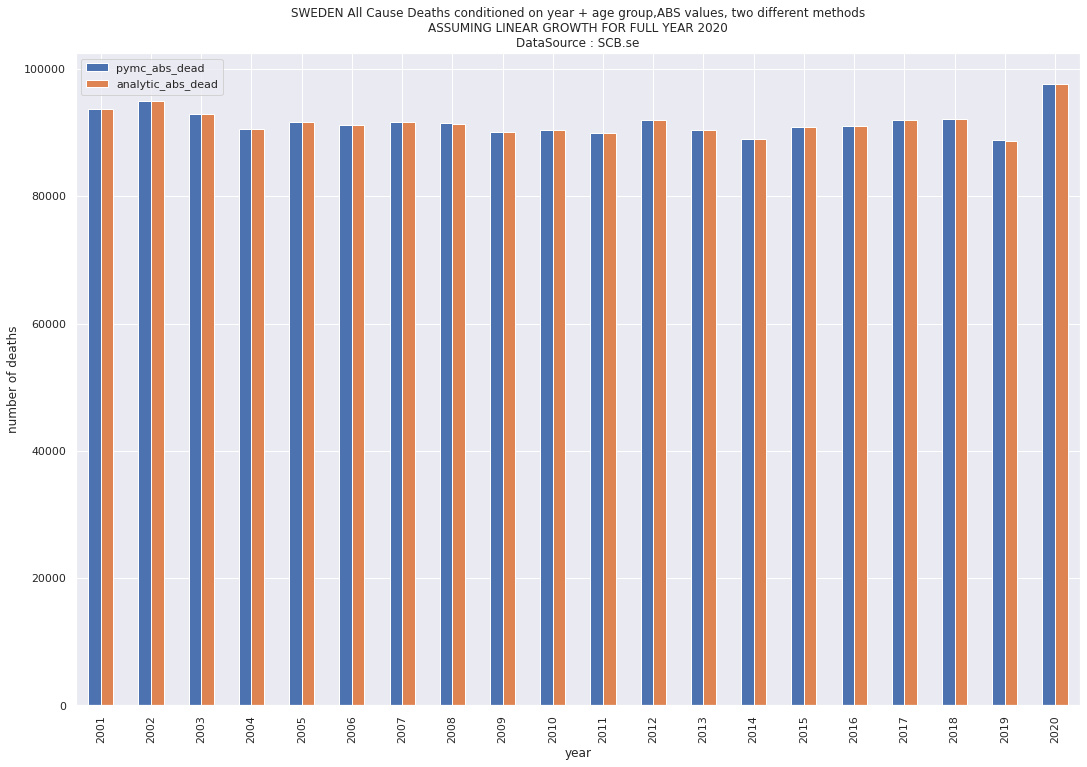

In [74]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group,ABS values, two different methods\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\nDataSource : SCB.se'

combined_abs_sums.plot(kind='bar',
                       figsize=(18,12),
                       title=title)
plt.ylabel('number of deaths')
plt.savefig('pymc_cond_year_age_abs.jpg',format='jpg')

In [75]:
yearly_pop = strata_abs_pop.sum(axis=1)

pop_adj_deaths = combined_abs_sums.div(yearly_pop / 1e6,axis=0)
pop_adj_deaths.columns = ['pymc_dead_per_M','analytic_dead_per_M']
pop_adj_deaths['factor'] = pop_adj_deaths['pymc_dead_per_M'] / pop_adj_deaths['analytic_dead_per_M']
pop_adj_deaths

,pymc_dead_per_M,analytic_dead_per_M,factor
year,,,
2001,10536.854467,10537.367524,0.999951
2002,10641.950110,10642.290978,0.999968
2003,10375.675748,10376.046426,0.999964
2004,10066.359824,10065.457049,1.000090
2005,10154.993647,10155.187865,0.999981
2006,10039.652115,10038.318906,1.000133
2007,10025.949342,10025.697162,1.000025
2008,9918.293140,9917.310193,1.000099
2009,9684.111285,9684.557679,0.999954


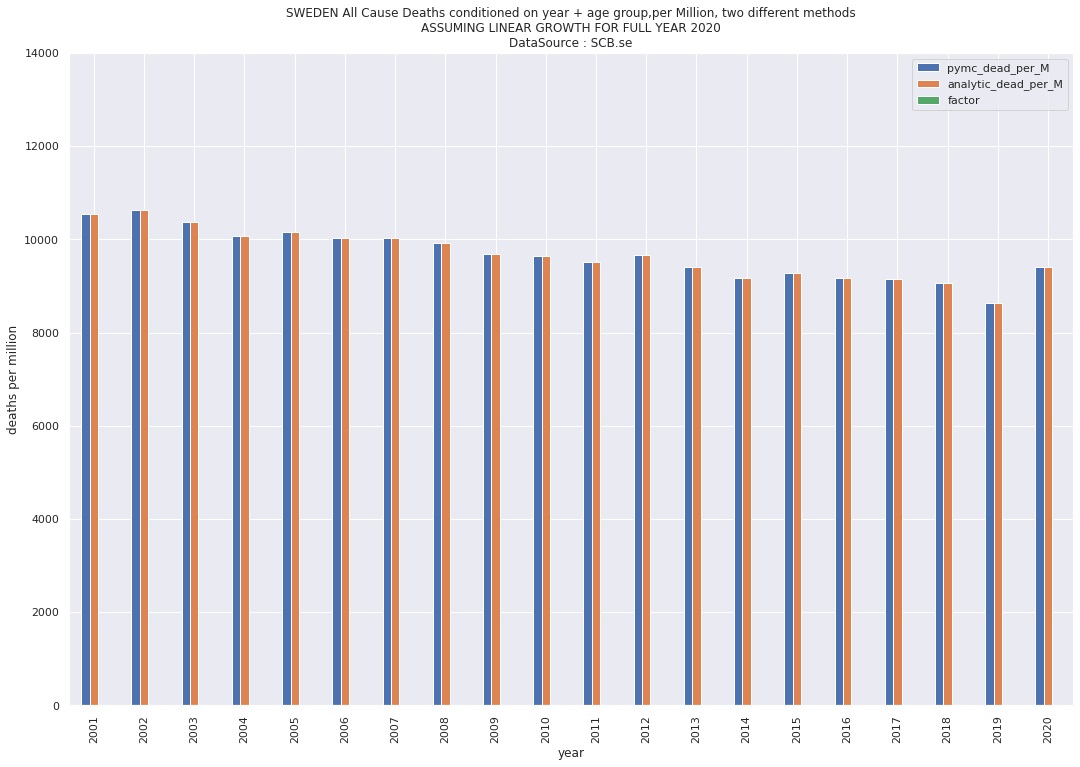

In [76]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group,per Million, two different methods\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\n'+\
'DataSource : SCB.se'
pop_adj_deaths.plot(kind='bar',figsize=(18,12),
                    title=title)

plt.ylabel('deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('pymc_cond_year_age_per_M.jpg',format='jpg')

In [77]:
pymc_deaths_per_M_per_age_grp = pymc_abs_deaths_cond_year_age.T / (yearly_pop / 1e6)
pymc_deaths_per_M_per_age_grp = pymc_deaths_per_M_per_age_grp.T

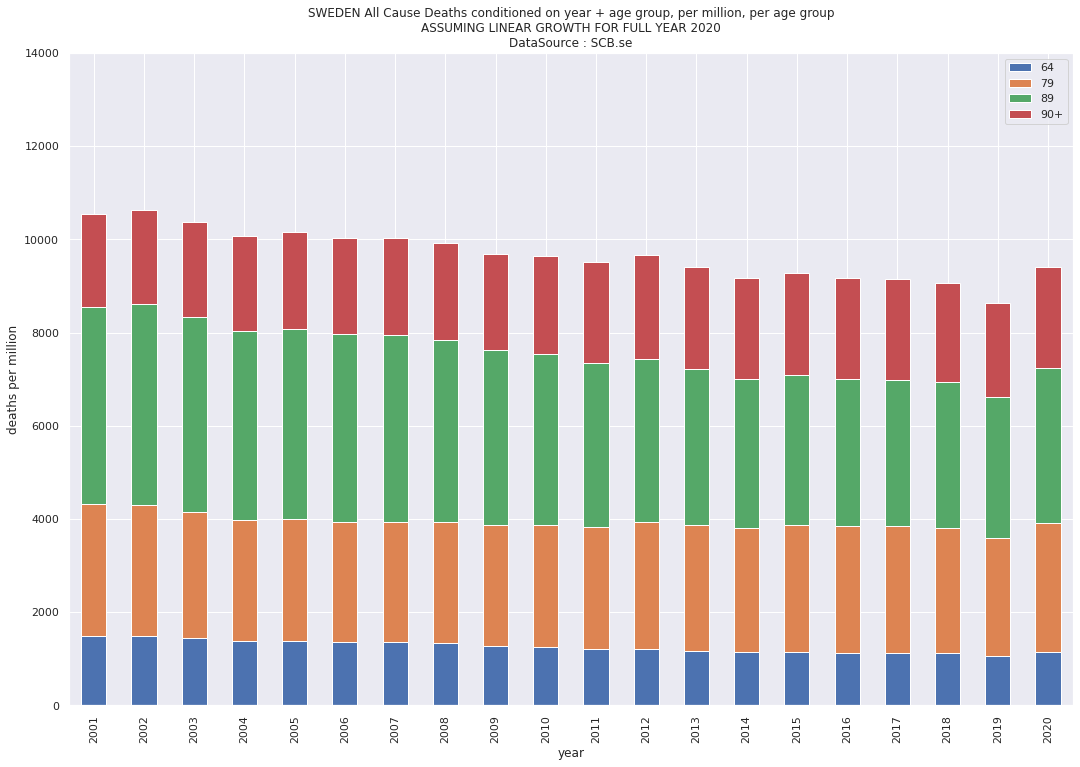

In [78]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group, per million, per age group\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\n'+\
'DataSource : SCB.se'
pymc_deaths_per_M_per_age_grp.plot(kind='bar',title=title,
                                   stacked=True,figsize=(18,12))
plt.ylabel('deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('pymc_cond_age_year_per_M_stratified.jpg',format='jpg')

In [79]:
### include median age of death as proxy for health

url4 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/LivslangdEttariga'
data4 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "BE0101A$"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [80]:
r4 = requests.post(url4,json=data4)
r4.status_code

200

In [81]:
json4 = r4.json()
json4['data'][0]

{'key': ['1', '0', '1960'], 'values': ['71.24']}

In [82]:
data_list4 = []

for rec in json4['data']:
    data_list4.append((rec['key'][0],rec['key'][2],rec['values'][0]))
    
median_age_of_death = pd.DataFrame(data_list4,columns=['gender','year','median'])
median_age_of_death.set_index('year',inplace=True)
median_age_of_death['median'] = median_age_of_death['median'].astype(float)

median_age_of_death

,gender,median
year,,
1960,1,71.24
1961,1,71.56
1962,1,71.32
1963,1,71.56
1964,1,71.66
...,...,...
2015,2,84.01
2016,2,84.09
2017,2,84.10


Text(0, 0.5, 'median age death')

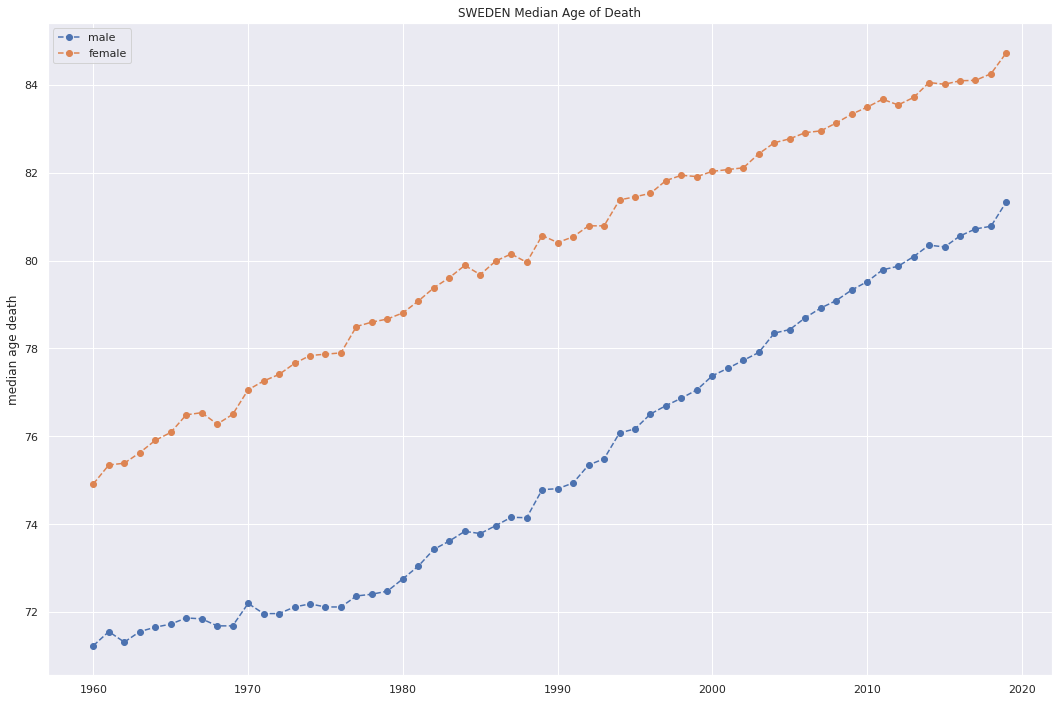

In [83]:
gender_groups = median_age_of_death.groupby('gender')

male = gender_groups.get_group('1')
male.index = range(1960,2020)

ax = male.plot(style='o--',figsize=(18,12))

female = gender_groups.get_group('2')
female.index = range(1960,2020)
female.plot(ax=ax,style='o--')

ax.legend(['male','female'])
plt.title('SWEDEN Median Age of Death')
plt.ylabel('median age death')

In [84]:
all_data

,age_grp,year,pop,dead,year_idx,age_idx
0,64,2001,7364484,13260,1,1
1,64,2002,7392028,13098,2,1
2,64,2003,7420704,13085,3,1
3,64,2004,7445736,13057,4,1
4,64,2005,7469716,13095,5,1
...,...,...,...,...,...,...
75,90+,2016,96741,22499,16,4
76,90+,2017,97251,22907,17,4
77,90+,2018,97843,22667,18,4
78,90+,2019,98965,21754,19,4


In [85]:
all_data_no_2020 = all_data.loc[all_data['year'] != 2020]

# use male median death as health proxy
all_data_no_2020 = all_data_no_2020.join(male,on='year')
all_data_no_2020['std_median'] = all_data_no_2020['median'].apply(
    lambda x : (x - all_data_no_2020['median'].mean()) / all_data_no_2020['median'].std())

all_data_no_2020['mortality'] = all_data_no_2020['dead'] / all_data_no_2020['pop']

all_data_no_2020['health_idx'] = all_data_no_2020['median'].astype(int) - 76 # index 1..5
all_data_no_2020['std_year'] = all_data_no_2020['year_idx'].apply(
    lambda x : (x - all_data_no_2020['year_idx'].mean()) / all_data_no_2020['year_idx'].std())

all_data_no_2020

,age_grp,year,pop,dead,year_idx,age_idx,gender,median,std_median,mortality,health_idx,std_year
0,64,2001,7364484,13260,1,1,1,77.55,-1.719877,0.001801,1,-1.632322
1,64,2002,7392028,13098,2,1,1,77.73,-1.555988,0.001772,1,-1.450953
2,64,2003,7420704,13085,3,1,1,77.91,-1.392099,0.001763,1,-1.269583
3,64,2004,7445736,13057,4,1,1,78.35,-0.991481,0.001754,2,-1.088214
4,64,2005,7469716,13095,5,1,1,78.43,-0.918642,0.001753,2,-0.906845
...,...,...,...,...,...,...,...,...,...,...,...,...
74,90+,2015,95679,22167,15,4,1,80.31,0.793089,0.231681,4,0.906845
75,90+,2016,96741,22499,16,4,1,80.56,1.020713,0.232569,4,1.088214
76,90+,2017,97251,22907,17,4,1,80.72,1.166392,0.235545,4,1.269583
77,90+,2018,97843,22667,18,4,1,80.78,1.221022,0.231667,4,1.450953


In [86]:
all_data_no_2020.loc[all_data_no_2020['year'].isin([2008,2009,2010,2011])]

,age_grp,year,pop,dead,year_idx,age_idx,gender,median,std_median,mortality,health_idx,std_year
7,64,2008,7592890,12848,8,1,1,79.09,-0.317715,0.001692,3,-0.362738
8,64,2009,7630585,12554,9,1,1,79.33,-0.099196,0.001645,3,-0.181369
9,64,2010,7664114,12153,10,1,1,79.52,0.073798,0.001586,3,0.000000
10,64,2011,7688255,11686,11,1,1,79.79,0.319632,0.001520,3,0.181369
27,79,2008,1134709,23500,8,2,1,79.09,-0.317715,0.020710,3,-0.362738
28,79,2009,1174180,23450,9,2,1,79.33,-0.099196,0.019971,3,-0.181369
29,79,2010,1218367,24012,10,2,1,79.52,0.073798,0.019708,3,0.000000
30,79,2011,1263396,23927,11,2,1,79.79,0.319632,0.018939,3,0.181369
47,89,2008,414587,36200,8,3,1,79.09,-0.317715,0.087316,3,-0.362738
48,89,2009,414772,35430,9,3,1,79.33,-0.099196,0.085420,3,-0.181369


In [87]:
all_data_no_2020.corr()

,year,pop,dead,year_idx,age_idx,median,std_median,mortality,health_idx,std_year
year,1.000000,0.034043,-0.025220,1.000000,0.000000e+00,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00
pop,0.034043,1.000000,-0.734906,0.034043,-8.502170e-01,0.033494,3.349434e-02,-0.621910,0.032221,3.404299e-02
dead,-0.025220,-0.734906,1.000000,-0.025220,4.370159e-01,-0.028296,-2.829628e-02,0.089094,-0.031165,-2.522024e-02
year_idx,1.000000,0.034043,-0.025220,1.000000,0.000000e+00,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00
age_idx,0.000000,-0.850217,0.437016,0.000000,1.000000e+00,0.000000,3.156669e-17,0.928627,0.000000,-5.261115e-18
median,0.994953,0.033494,-0.028296,0.994953,0.000000e+00,1.000000,1.000000e+00,-0.042122,0.976663,9.949532e-01
std_median,0.994953,0.033494,-0.028296,0.994953,3.156669e-17,1.000000,1.000000e+00,-0.042122,0.976663,9.949532e-01
mortality,-0.041290,-0.621910,0.089094,-0.041290,9.286268e-01,-0.042122,-4.212214e-02,1.000000,-0.042211,-4.129049e-02
health_idx,0.965000,0.032221,-0.031165,0.965000,0.000000e+00,0.976663,9.766633e-01,-0.042211,1.000000,9.649997e-01
std_year,1.000000,0.034043,-0.025220,1.000000,-5.261115e-18,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 30_000 tune and 50_000 draw iterations (60_000 + 100_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0]   0.22  0.03    0.18     0.27       0.02     0.01      2.55    2.55   
alpha[1]   0.22  0.03    0.18     0.27       0.02     0.01      2.55    2.55   
alpha[2]   0.19  0.03    0.14     0.24       0.02     0.01      2.54    2.54   
alpha[3]   0.15  0.03    0.10     0.20       0.02     0.01      2.54    2.54   
alpha[4]   0.15  0.03    0.10     0.20       0.02     0.01      2.55    2.55   
alpha[5]   0.13  0.03    0.09     0.18       0.02     0.01      2.57    2.57   
alpha[6]   0.13  0.03    0.08     0.18       0.02     0.01      2.55    2.55   
alpha[7]   0.11  0.03    0.07     0.16       0.02     0.01      2.56    2.56   
alpha[8]   0.08  0.03    0.04     0.13       0.02     0.01      2.56    2.56   
alpha[9]   0.06  0.03    0.02     0.11       0.02     0.01      2.56    2.56   
alpha[10]  0.03  0.03   -0.01     0.08       0.02     0.01      2.54    2.54   
alpha[11]  0.04  0.03   -0.00     0.09  

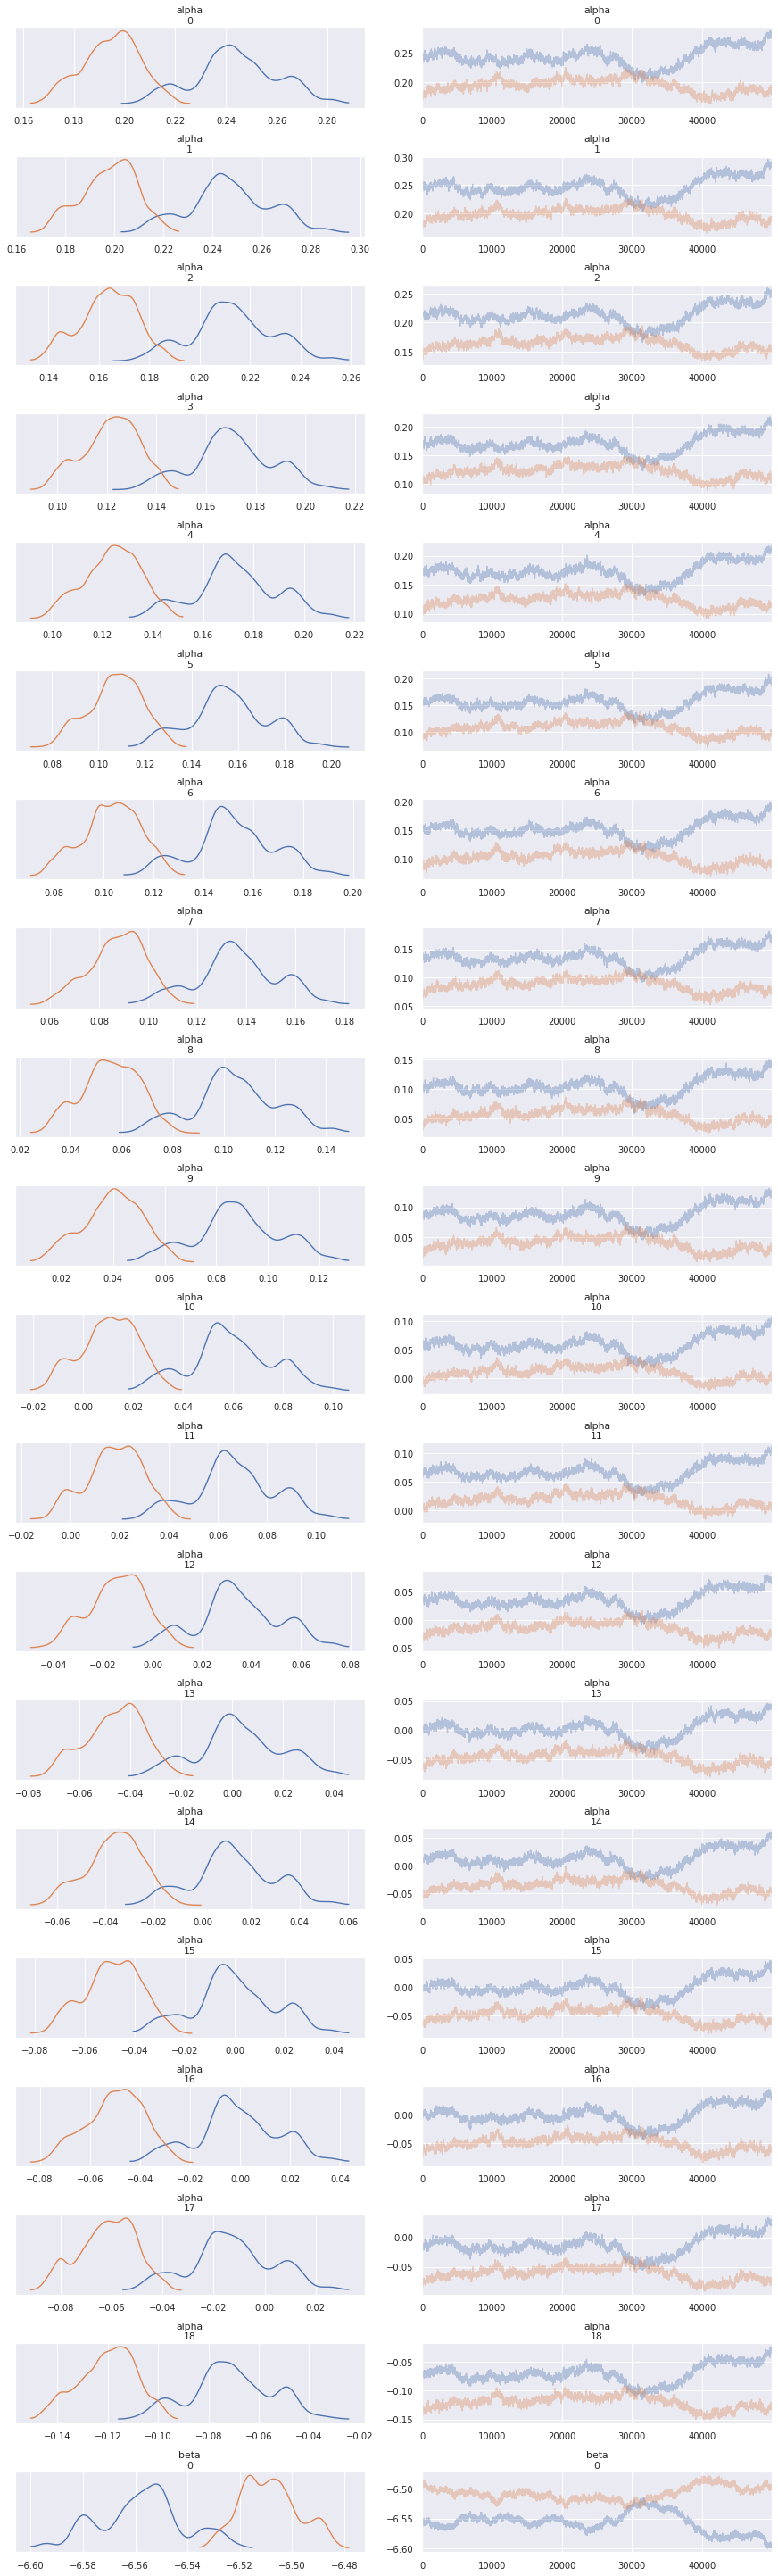

In [88]:
model2 = pm.Model()
with model2:
    
    alpha = pm.Normal('alpha', 0, sigma=10,shape=19)
    beta = pm.Normal('beta',0, sigma=10,shape=4)

    age_idx = all_data_no_2020['age_idx']
    year_idx = all_data_no_2020['year_idx']


    lgit = np.exp(alpha[year_idx-1]   + beta[age_idx-1]) / (
            1 + np.exp(alpha[year_idx-1]  + beta[age_idx-1] ))

    likelihood = pm.Binomial('likelihood',n=all_data_no_2020['pop'],p=lgit,observed=all_data_no_2020['dead'])
    step1 = pm.Metropolis([alpha,beta])
    
    
    trace2 = pm.sample(50000,step1,tune=30000)
    
    _= az.plot_trace(trace2)
    print(az.summary(trace2,round_to=2))
    
    

In [89]:
alpha_post = trace2['alpha'][:]
beta_post = trace2['beta'][:]



result = pd.DataFrame(alpha_post)

In [90]:
result.columns = range(2001,2020)
result = pd.concat([result,pd.DataFrame(beta_post)],axis=1)


In [91]:
result.describe()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,0,1,2,3
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.219311,0.222340,0.188259,0.146139,0.148526,0.131692,0.127662,0.111989,0.079895,0.064085,...,-0.021478,-0.011698,-0.024380,-0.025478,-0.037169,-0.095540,-6.532789,-3.946543,-2.463651,-1.231784
std,0.028376,0.028276,0.028235,0.028207,0.028189,0.028226,0.028341,0.028151,0.028102,0.028118,...,0.028277,0.028351,0.028161,0.028128,0.028224,0.028355,0.028047,0.028080,0.028061,0.028101
min,0.162918,0.165821,0.133016,0.089336,0.091512,0.070886,0.070765,0.052176,0.024273,0.008037,...,-0.079134,-0.070825,-0.081774,-0.083629,-0.091609,-0.150667,-6.600017,-4.012823,-2.530216,-1.300772
25%,0.195564,0.198957,0.164447,0.122680,0.124760,0.108076,0.103841,0.088617,0.055892,0.040502,...,-0.044831,-0.035385,-0.048221,-0.048973,-0.060774,-0.119098,-6.556408,-3.970031,-2.487065,-1.255399
50%,0.213515,0.216439,0.183175,0.140184,0.142597,0.126018,0.121770,0.105598,0.073622,0.058528,...,-0.027373,-0.017560,-0.030103,-0.031286,-0.043314,-0.100882,-6.527068,-3.940743,-2.457782,-1.225850
75%,0.243213,0.245925,0.212344,0.169939,0.172025,0.155411,0.151242,0.135626,0.103456,0.087831,...,0.001892,0.011824,-0.001198,-0.002097,-0.013543,-0.071562,-6.509056,-3.922782,-2.439952,-1.208031
max,0.288420,0.295358,0.259197,0.217497,0.217786,0.207568,0.198253,0.181719,0.148927,0.131372,...,0.045756,0.060213,0.045742,0.043405,0.032892,-0.024276,-6.478264,-3.893139,-2.411512,-1.178489


In [92]:
result.columns = ['alpha_2001','alpha_2002','alpha_2003','alpha_2004','alpha_2005',
                 'alpha_2006','alpha_2007','alpha_2008','alpha_2009','alpha_2010',
                 'alpha_2011','alpha_2012','alpha_2013','alpha_2014','alpha_2015',
                 'alpha_2016','alpha_2017','alpha_2018','alpha_2019','beta_64','beta_79',
                 'beta_89','beta_90']
result.describe()

,alpha_2001,alpha_2002,alpha_2003,alpha_2004,alpha_2005,alpha_2006,alpha_2007,alpha_2008,alpha_2009,alpha_2010,...,alpha_2014,alpha_2015,alpha_2016,alpha_2017,alpha_2018,alpha_2019,beta_64,beta_79,beta_89,beta_90
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.219311,0.222340,0.188259,0.146139,0.148526,0.131692,0.127662,0.111989,0.079895,0.064085,...,-0.021478,-0.011698,-0.024380,-0.025478,-0.037169,-0.095540,-6.532789,-3.946543,-2.463651,-1.231784
std,0.028376,0.028276,0.028235,0.028207,0.028189,0.028226,0.028341,0.028151,0.028102,0.028118,...,0.028277,0.028351,0.028161,0.028128,0.028224,0.028355,0.028047,0.028080,0.028061,0.028101
min,0.162918,0.165821,0.133016,0.089336,0.091512,0.070886,0.070765,0.052176,0.024273,0.008037,...,-0.079134,-0.070825,-0.081774,-0.083629,-0.091609,-0.150667,-6.600017,-4.012823,-2.530216,-1.300772
25%,0.195564,0.198957,0.164447,0.122680,0.124760,0.108076,0.103841,0.088617,0.055892,0.040502,...,-0.044831,-0.035385,-0.048221,-0.048973,-0.060774,-0.119098,-6.556408,-3.970031,-2.487065,-1.255399
50%,0.213515,0.216439,0.183175,0.140184,0.142597,0.126018,0.121770,0.105598,0.073622,0.058528,...,-0.027373,-0.017560,-0.030103,-0.031286,-0.043314,-0.100882,-6.527068,-3.940743,-2.457782,-1.225850
75%,0.243213,0.245925,0.212344,0.169939,0.172025,0.155411,0.151242,0.135626,0.103456,0.087831,...,0.001892,0.011824,-0.001198,-0.002097,-0.013543,-0.071562,-6.509056,-3.922782,-2.439952,-1.208031
max,0.288420,0.295358,0.259197,0.217497,0.217786,0.207568,0.198253,0.181719,0.148927,0.131372,...,0.045756,0.060213,0.045742,0.043405,0.032892,-0.024276,-6.478264,-3.893139,-2.411512,-1.178489


In [93]:
result_p = pd.DataFrame()

result_p['2001_64'] = logit_pure(result['alpha_2001'] + result['beta_64'])
result_p['2001_79'] = logit_pure(result['alpha_2001'] + result['beta_79'])
result_p['2001_89'] = logit_pure(result['alpha_2001'] + result['beta_89'])
result_p['2001_90'] = logit_pure(result['alpha_2001'] + result['beta_90'])

result_p['2002_64'] = logit_pure(result['alpha_2002'] + result['beta_64'])
result_p['2002_79'] = logit_pure(result['alpha_2002'] + result['beta_79'])
result_p['2002_89'] = logit_pure(result['alpha_2002'] + result['beta_89'])
result_p['2002_90'] = logit_pure(result['alpha_2002'] + result['beta_90'])

result_p['2003_64'] = logit_pure(result['alpha_2003'] + result['beta_64'])
result_p['2003_79'] = logit_pure(result['alpha_2003'] + result['beta_79'])
result_p['2003_89'] = logit_pure(result['alpha_2003'] + result['beta_89'])
result_p['2003_90'] = logit_pure(result['alpha_2003'] + result['beta_90'])

result_p['2004_64'] = logit_pure(result['alpha_2004'] + result['beta_64'])
result_p['2004_79'] = logit_pure(result['alpha_2004'] + result['beta_79'])
result_p['2004_89'] = logit_pure(result['alpha_2004'] + result['beta_89'])
result_p['2004_90'] = logit_pure(result['alpha_2004'] + result['beta_90'])

result_p['2005_64'] = logit_pure(result['alpha_2005'] + result['beta_64'])
result_p['2005_79'] = logit_pure(result['alpha_2005'] + result['beta_79'])
result_p['2005_89'] = logit_pure(result['alpha_2005'] + result['beta_89'])
result_p['2005_90'] = logit_pure(result['alpha_2005'] + result['beta_90'])

result_p['2006_64'] = logit_pure(result['alpha_2006'] + result['beta_64'])
result_p['2006_79'] = logit_pure(result['alpha_2006'] + result['beta_79'])
result_p['2006_89'] = logit_pure(result['alpha_2006'] + result['beta_89'])
result_p['2006_90'] = logit_pure(result['alpha_2006'] + result['beta_90'])

result_p['2007_64'] = logit_pure(result['alpha_2007'] + result['beta_64'])
result_p['2007_79'] = logit_pure(result['alpha_2007'] + result['beta_79'])
result_p['2007_89'] = logit_pure(result['alpha_2007'] + result['beta_89'])
result_p['2007_90'] = logit_pure(result['alpha_2007'] + result['beta_90'])

result_p['2008_64'] = logit_pure(result['alpha_2008'] + result['beta_64'])
result_p['2008_79'] = logit_pure(result['alpha_2008'] + result['beta_79'])
result_p['2008_89'] = logit_pure(result['alpha_2008'] + result['beta_89'])
result_p['2008_90'] = logit_pure(result['alpha_2008'] + result['beta_90'])

result_p['2009_64'] = logit_pure(result['alpha_2009'] + result['beta_64'])
result_p['2009_79'] = logit_pure(result['alpha_2009'] + result['beta_79'])
result_p['2009_89'] = logit_pure(result['alpha_2009'] + result['beta_89'])
result_p['2009_90'] = logit_pure(result['alpha_2009'] + result['beta_90'])

result_p['2010_64'] = logit_pure(result['alpha_2010'] + result['beta_64'])
result_p['2010_79'] = logit_pure(result['alpha_2010'] + result['beta_79'])
result_p['2010_89'] = logit_pure(result['alpha_2010'] + result['beta_89'])
result_p['2010_90'] = logit_pure(result['alpha_2010'] + result['beta_90'])

result_p['2011_64'] = logit_pure(result['alpha_2011'] + result['beta_64'])
result_p['2011_79'] = logit_pure(result['alpha_2011'] + result['beta_79'])
result_p['2011_89'] = logit_pure(result['alpha_2011'] + result['beta_89'])
result_p['2011_90'] = logit_pure(result['alpha_2011'] + result['beta_90'])

result_p['2012_64'] = logit_pure(result['alpha_2012'] + result['beta_64'])
result_p['2012_79'] = logit_pure(result['alpha_2012'] + result['beta_79'])
result_p['2012_89'] = logit_pure(result['alpha_2012'] + result['beta_89'])
result_p['2012_90'] = logit_pure(result['alpha_2012'] + result['beta_90'])

result_p['2013_64'] = logit_pure(result['alpha_2013'] + result['beta_64'])
result_p['2013_79'] = logit_pure(result['alpha_2013'] + result['beta_79'])
result_p['2013_89'] = logit_pure(result['alpha_2013'] + result['beta_89'])
result_p['2013_90'] = logit_pure(result['alpha_2013'] + result['beta_90'])

result_p['2014_64'] = logit_pure(result['alpha_2014'] + result['beta_64'])
result_p['2014_79'] = logit_pure(result['alpha_2014'] + result['beta_79'])
result_p['2014_89'] = logit_pure(result['alpha_2014'] + result['beta_89'])
result_p['2014_90'] = logit_pure(result['alpha_2014'] + result['beta_90'])

result_p['2015_64'] = logit_pure(result['alpha_2015'] + result['beta_64'])
result_p['2015_79'] = logit_pure(result['alpha_2015'] + result['beta_79'])
result_p['2015_89'] = logit_pure(result['alpha_2015'] + result['beta_89'])
result_p['2015_90'] = logit_pure(result['alpha_2015'] + result['beta_90'])

result_p['2016_64'] = logit_pure(result['alpha_2016'] + result['beta_64'])
result_p['2016_79'] = logit_pure(result['alpha_2016'] + result['beta_79'])
result_p['2016_89'] = logit_pure(result['alpha_2016'] + result['beta_89'])
result_p['2016_90'] = logit_pure(result['alpha_2016'] + result['beta_90'])

result_p['2017_64'] = logit_pure(result['alpha_2017'] + result['beta_64'])
result_p['2017_79'] = logit_pure(result['alpha_2017'] + result['beta_79'])
result_p['2017_89'] = logit_pure(result['alpha_2017'] + result['beta_89'])
result_p['2017_90'] = logit_pure(result['alpha_2017'] + result['beta_90'])

result_p['2018_64'] = logit_pure(result['alpha_2018'] + result['beta_64'])
result_p['2018_79'] = logit_pure(result['alpha_2018'] + result['beta_79'])
result_p['2018_89'] = logit_pure(result['alpha_2018'] + result['beta_89'])
result_p['2018_90'] = logit_pure(result['alpha_2018'] + result['beta_90'])

result_p['2019_64'] = logit_pure(result['alpha_2019'] + result['beta_64'])
result_p['2019_79'] = logit_pure(result['alpha_2019'] + result['beta_79'])
result_p['2019_89'] = logit_pure(result['alpha_2019'] + result['beta_89'])
result_p['2019_90'] = logit_pure(result['alpha_2019'] + result['beta_90'])



In [94]:
result_p.describe()

,2001_64,2001_79,2001_89,2001_90,2002_64,2002_79,2002_89,2002_90,2003_64,2003_79,...,2017_89,2017_90,2018_64,2018_79,2018_89,2018_90,2019_64,2019_79,2019_89,2019_90
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001808,0.023494,0.095839,0.266497,0.001814,0.023564,0.096102,0.267089,0.001753,0.022792,...,0.076624,0.221446,0.001400,0.018276,0.075801,0.219437,0.001321,0.017258,0.071812,0.209603
std,0.000007,0.000083,0.000310,0.000757,0.000007,0.000084,0.000311,0.000761,0.000007,0.000080,...,0.000263,0.000669,0.000006,0.000065,0.000255,0.000657,0.000005,0.000062,0.000242,0.000631
min,0.001775,0.023131,0.094387,0.263137,0.001782,0.023221,0.094707,0.264060,0.001725,0.022445,...,0.075523,0.218584,0.001377,0.018012,0.074805,0.216988,0.001298,0.016975,0.070778,0.207081
25%,0.001804,0.023438,0.095631,0.265992,0.001809,0.023507,0.095893,0.266575,0.001749,0.022739,...,0.076449,0.220997,0.001396,0.018232,0.075627,0.218995,0.001317,0.017216,0.071646,0.209173
50%,0.001808,0.023494,0.095838,0.266498,0.001814,0.023563,0.096099,0.267091,0.001753,0.022793,...,0.076624,0.221448,0.001400,0.018276,0.075801,0.219437,0.001321,0.017258,0.071810,0.209594
75%,0.001813,0.023549,0.096044,0.267000,0.001819,0.023619,0.096311,0.267599,0.001758,0.022846,...,0.076798,0.221892,0.001404,0.018320,0.075973,0.219872,0.001324,0.017300,0.071975,0.210031
max,0.001837,0.023847,0.097138,0.269536,0.001845,0.023937,0.097378,0.270196,0.001780,0.023104,...,0.077859,0.224513,0.001423,0.018539,0.076818,0.222004,0.001341,0.017489,0.072752,0.212146


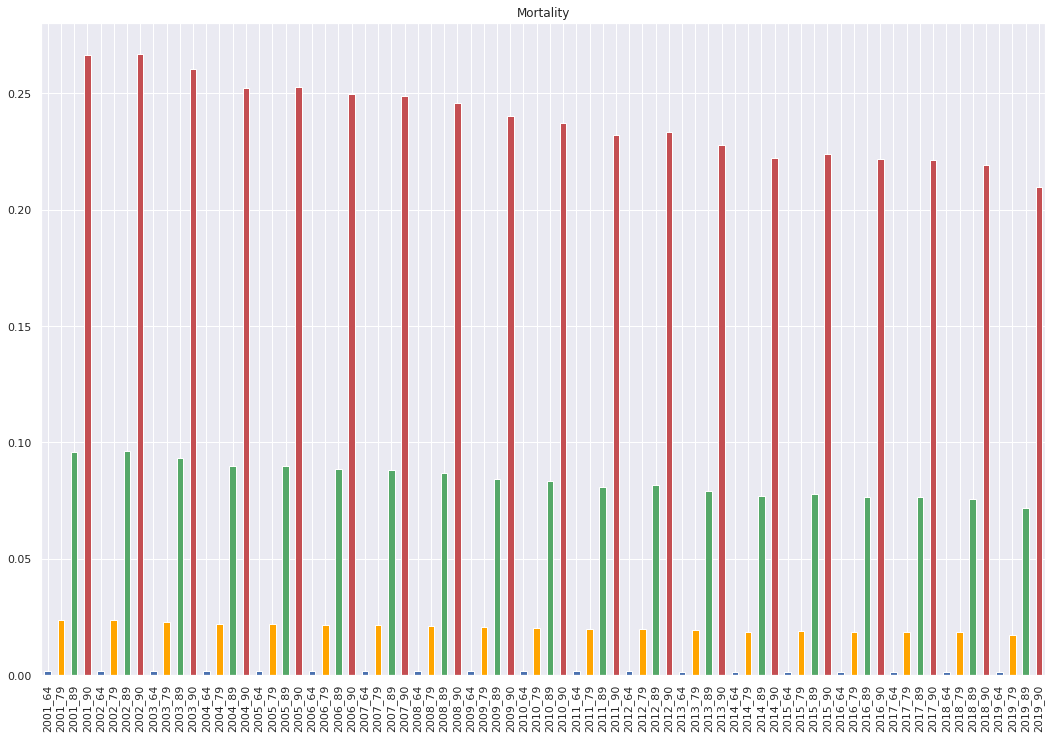

In [95]:
plt.figure(figsize=(18,12))
plt.title('Mortality')
result_p.describe().loc['mean'].plot(kind='bar',color=['b','orange','g','r'])
_= plt.xticks(rotation=90)

In [96]:
abs_pop_no_2020 = strata_abs_pop.loc[2001:2019]
abs_pop_no_2020

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0
2006,7507097.5,1084698.5,413877.0,74831.5
2007,7553167.0,1104317.0,414345.5,76262.5
2008,7592890.0,1134709.5,414587.5,77450.0
2009,7630585.5,1174180.0,414772.5,78976.5


In [97]:
p_means = result_p.describe().loc['mean']
p_means = p_means.reset_index()
p_means[['year','age_grp']] = p_means['index'].str.split('_',1,expand=True)
p_means = pd.pivot(p_means,index='age_grp',columns='year',values='mean')
p_means = p_means.T
p_means.rename(columns={'90' : '90+'},inplace=True)
p_means.index = range(2001,2020)
p_means

age_grp,64,79,89,90+
2001,0.001808,0.023494,0.095839,0.266497
2002,0.001814,0.023564,0.096102,0.267089
2003,0.001753,0.022792,0.093182,0.260471
2004,0.001681,0.021873,0.089683,0.252440
2005,0.001685,0.021924,0.089878,0.252891
2006,0.001657,0.021566,0.088511,0.249723
2007,0.001650,0.021481,0.088186,0.248969
2008,0.001625,0.021154,0.086934,0.246050
2009,0.001573,0.020500,0.084420,0.240145
2010,0.001549,0.020184,0.083206,0.237272


In [98]:
abs_d = p_means * abs_pop_no_2020
abs_d

age_grp,64,79,89,90+
2001,13318.366568,25211.388553,37598.340951,17610.104730
2002,13408.666558,25120.469763,38356.190647,18095.034095
2003,13010.444675,24269.032580,37572.984095,18105.472183
2004,12516.805791,23374.466667,36542.328088,18094.380189
2005,12587.086271,23570.504553,36966.653845,18575.831018
2006,12439.253048,23392.387473,36632.615943,18687.166844
2007,12465.333609,23721.743145,36539.583634,18986.992668
2008,12336.342460,24003.579787,36041.804588,19056.566083
2009,12006.639896,24070.118283,35015.180476,18965.805560
2010,11870.525751,24592.069878,34346.059126,19660.816800


In [99]:
abs_d.sum(axis=1)

2001    93738.200801
2002    94980.361064
2003    92957.933533
2004    90527.980735
2005    91700.075687
2006    91151.423307
2007    91713.653057
2008    91438.292918
2009    90057.744216
2010    90469.471555
2011    89925.120677
2012    91923.798247
2013    90376.315963
2014    88964.667043
2015    90921.957482
2016    90966.811679
2017    91963.212020
2018    92167.554775
2019    88762.127682
dtype: float64

<AxesSubplot:>

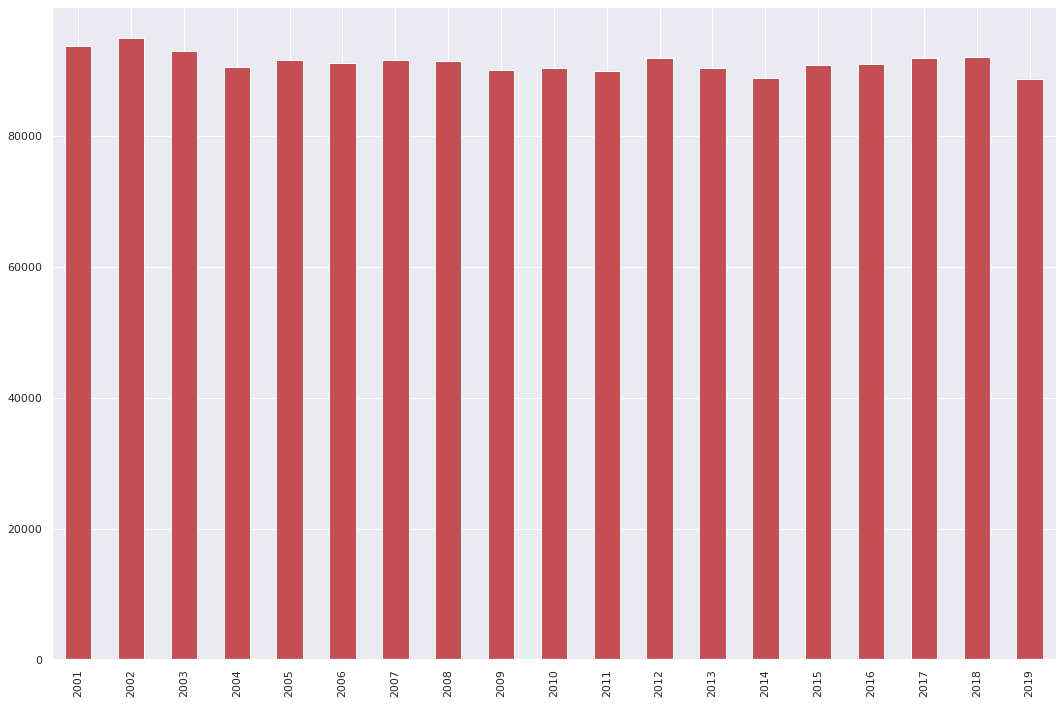

In [100]:
abs_d.sum(axis=1).plot(kind='bar',figsize=(18,12),color='r')

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.
The number of effective samples is smaller than 10% for some parameters.


          mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha[0] -6.46  0.0   -6.47    -6.46        0.0      0.0    523.21   523.21   
alpha[1] -3.88  0.0   -3.88    -3.87        0.0      0.0    680.01   680.00   
alpha[2] -2.39  0.0   -2.40    -2.39        0.0      0.0    804.02   804.02   
alpha[3] -1.16  0.0   -1.17    -1.16        0.0      0.0    578.65   578.65   
beta     -0.09  0.0   -0.09    -0.09        0.0      0.0   1002.65  1002.65   

          ess_bulk  ess_tail  r_hat  
alpha[0]    524.62    812.43    1.0  
alpha[1]    681.97   1003.23    1.0  
alpha[2]    808.61   1055.20    1.0  
alpha[3]    582.55    844.77    1.0  
beta       1017.16    933.25    1.0  


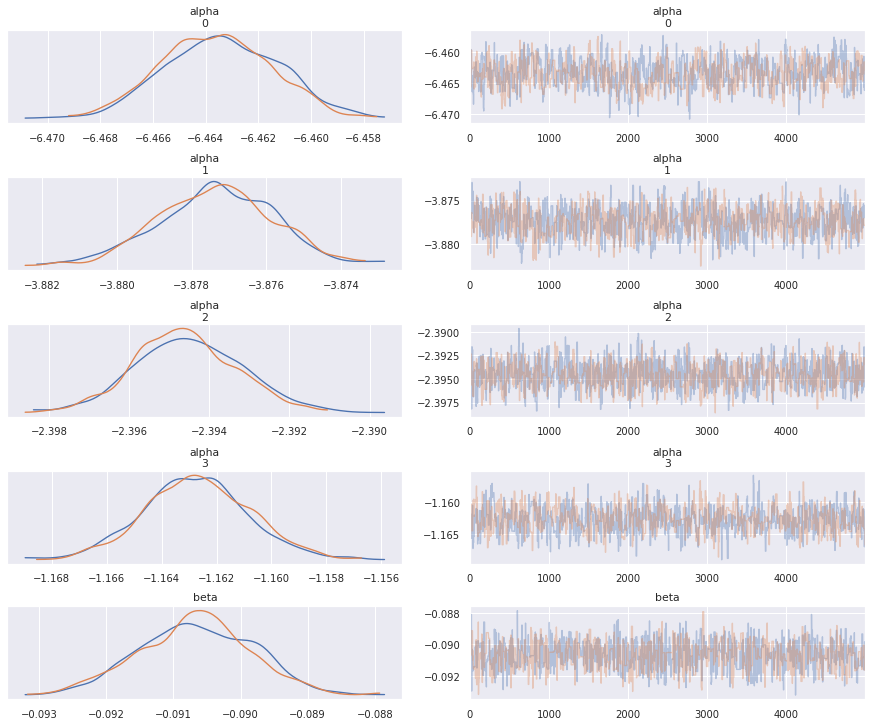

In [101]:
model3 = pm.Model()
with model3:
    
    alpha = pm.Normal('alpha', 0, sigma=10,shape=4)
    beta = pm.Normal('beta',0, sigma=10)

    std_year = all_data_no_2020['std_year']
    age_idx = all_data_no_2020['age_idx']

    lgit = np.exp(alpha[age_idx-1]   + beta * std_year) / (
            1 + np.exp(alpha[age_idx-1]  + beta * std_year ))

    likelihood = pm.Binomial('likelihood',n=all_data_no_2020['pop'],p=lgit,observed=all_data_no_2020['dead'])
    step1 = pm.Metropolis([alpha,beta])
    trace3 = pm.sample(5000,step1,tune=1000)
    az.plot_trace(trace3)
    print(az.summary(trace3,round_to=2))
    
    
    

In [102]:
alpha_post = trace3['alpha'][:]
beta_post = trace3['beta'][:]



In [103]:
result=pd.DataFrame({'64' : alpha_post[:,0],'79' : alpha_post[:,1],
                    '89' : alpha_post[:,2],'90' : alpha_post[:,3],
                    'beta' : beta_post})

In [104]:
result.describe()


,64,79,89,90,beta
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-6.463481,-3.877330,-2.394553,-1.162719,-0.090667
std,0.002125,0.001545,0.001300,0.001879,0.000821
min,-6.470850,-3.882452,-2.398597,-1.168969,-0.093207
25%,-6.464989,-3.878372,-2.395461,-1.163992,-0.091233
50%,-6.463478,-3.877311,-2.394591,-1.162750,-0.090664
75%,-6.461956,-3.876255,-2.393666,-1.161507,-0.090077
max,-6.457210,-3.872839,-2.389626,-1.155882,-0.087856


In [105]:
result_p = pd.DataFrame()
result_p['64'] = logit_pure(result['64'] + result['beta'])
result_p['79'] = logit_pure(result['79'] + result['beta'])
result_p['89'] = logit_pure(result['89'] + result['beta'])
result_p['90'] = logit_pure(result['90'] + result['beta'])

result_p.describe()

,64,79,89,90
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.001422,0.018560,0.076901,0.222115
std,0.000003,0.000031,0.000110,0.000351
min,0.001411,0.018448,0.076482,0.220873
25%,0.001420,0.018539,0.076828,0.221881
50%,0.001422,0.018560,0.076898,0.222105
75%,0.001424,0.018582,0.076974,0.222356
max,0.001432,0.018667,0.077275,0.223291
